In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/sample_submission_UVKGLZE.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/train.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/test.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/labels.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/vocab.txt
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/bert_model.ckpt.index
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/bert_config.json
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001
/kaggle/input/glove6b200d/glove.6B.200d.txt


Topic Modeling for Research Articles
Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process.

Given the abstract and title for a set of research articles, predict the topics for each article included in the test set. 

Note that a research article can possibly have more than 1 topic. The research article abstracts and titles are sourced from the following 6 topics: 

1. Computer Science

2. Physics

3. Mathematics

4. Statistics

5. Quantitative Biology

6. Quantitative Finance

Evaluation Metric
Submissions are evaluated on micro F1 Score between the predicted and observed topics for each article in the test set

In [2]:
# import the standard libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth',300)


In [3]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as ltb
import catboost as ctb

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from scipy.stats import uniform

In [4]:
# standard libs related to keras - deep learning modules
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Conv1D
from keras.layers import Flatten, LSTM,GRU
from keras.layers import GlobalMaxPooling1D,MaxPooling1D,BatchNormalization
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [5]:
# Read the datafile and store in df's

train = pd.read_csv('/kaggle/input/janatahack-independence-day-2020-ml-hackathon/train.csv')
test  = pd.read_csv('/kaggle/input/janatahack-independence-day-2020-ml-hackathon/test.csv')
sub   = pd.read_csv('/kaggle/input/janatahack-independence-day-2020-ml-hackathon/sample_submission_UVKGLZE.csv')

In [6]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,"Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each i...",1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,"Rotation invariance and translation invariance have great values in image\nrecognition tasks. In this paper, we bring a new architecture in convolutional\nneural network (CNN) named cyclic convolutional layer to achieve rotation\ninvariance in 2-D symbol recognition. We can also get the positi...",1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels for polyharmonic functions,"We introduce and develop the notion of spherical polyharmonics, which are a\nnatural generalisation of spherical harmonics. In particular we study the\ntheory of zonal polyharmonics, which allows us, analogously to zonal harmonics,\nto construct Poisson kernels for polyharmonic functions on th...",0,0,1,0,0,0
3,4,A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system,The stochastic Landau--Lifshitz--Gilbert (LLG) equation coupled with the\nMaxwell equations (the so called stochastic MLLG system) describes the creation\nof domain walls and vortices (fundamental objects for the novel nanostructured\nmagnetic memories). We first reformulate the stochastic LLG...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transforms and Wavelet Tensor Train decomposition to feature extraction of FTIR data of medicinal plants,Fourier-transform infra-red (FTIR) spectra of samples from 7 plant species\nwere used to explore the influence of preprocessing and feature extraction on\nefficiency of machine learning algorithms. Wavelet Tensor Train (WTT) and\nDiscrete Wavelet Transforms (DWT) were compared as feature extra...,1,0,0,1,0,0


In [7]:
test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poisson Matrix Factorization,"We present novel understandings of the Gamma-Poisson (GaP) model, a\nprobabilistic matrix factorization model for count data. We show that GaP can\nbe rewritten free of the score/activation matrix. This gives us new insights\nabout the estimation of the topic/dictionary matrix by maximum margi..."
1,20974,Laboratory mid-IR spectra of equilibrated and igneous meteorites. Searching for observables of planetesimal debris,"Meteorites contain minerals from Solar System asteroids with different\nproperties (like size, presence of water, core formation). We provide new\nmid-IR transmission spectra of powdered meteorites to obtain templates of how\nmid-IR spectra of asteroidal debris would look like. This is essenti..."
2,20975,Case For Static AMSDU Aggregation in WLANs,"Frame aggregation is a mechanism by which multiple frames are combined into a\nsingle transmission unit over the air. Frames aggregated at the AMSDU level use\na common CRC check to enforce integrity. For longer aggregated AMSDU frames,\nthe packet error rate increases significantly for the sa..."
3,20976,The $Gaia$-ESO Survey: the inner disk intermediate-age open cluster NGC 6802,"Milky Way open clusters are very diverse in terms of age, chemical\ncomposition, and kinematic properties. Intermediate-age and old open clusters\nare less common, and it is even harder to find them inside the solar\nGalactocentric radius, due to the high mortality rate and strong extinction\n..."
4,20977,Witness-Functions versus Interpretation-Functions for Secrecy in Cryptographic Protocols: What to Choose?,"Proving that a cryptographic protocol is correct for secrecy is a hard task.\nOne of the strongest strategies to reach this goal is to show that it is\nincreasing, which means that the security level of every single atomic message\nexchanged in the protocol, safely evaluated, never deceases. R..."


In [8]:
sub.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,0,0,0
1,20974,0,0,0,0,0,0
2,20975,0,0,0,0,0,0
3,20976,0,0,0,0,0,0
4,20977,0,0,0,0,0,0


In [9]:
train.shape,test.shape,sub.shape

((20972, 9), (8989, 3), (8989, 7))

In [10]:
train.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [11]:
train.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [12]:
test.isnull().sum()

ID          0
TITLE       0
ABSTRACT    0
dtype: int64

In [13]:
train.dtypes

ID                       int64
TITLE                   object
ABSTRACT                object
Computer Science         int64
Physics                  int64
Mathematics              int64
Statistics               int64
Quantitative Biology     int64
Quantitative Finance     int64
dtype: object

In [14]:
train['TITLE'].sample(5,random_state=11)

12645                                              Gridbot: An autonomous robot controlled by a Spiking Neural Network mimicking the brain's navigational system
9442                                                                                                              Multi-model ensembles for ecosystem prediction
12121    Acceleration of Convergence of Some Infinite Sequences $\boldsymbol{\{A_n\}}$ Whose Asymptotic Expansions Involve Fractional Powers of $\boldsymbol{n}$
4141                                                             Face Detection and Face Recognition In the Wild Using Off-the-Shelf Freely Available Components
3818                                                                                                      Making Neural QA as Simple as Possible but not Simpler
Name: TITLE, dtype: object

In [15]:
train['ABSTRACT'].sample(5,random_state=11)

12645      It is true that the "best" neural network is not necessarily the one with the\nmost "brain-like" behavior. Understanding biological intelligence, however, is\na fundamental goal for several distinct disciplines. Translating our\nunderstanding of intelligence to machines is a fundamental proble...
9442       When making predictions about ecosystems, we often have available a number of\ndifferent ecosystem models that attempt to represent their dynamics in a\ndetailed mechanistic way. Each of these can be used as simulators of\nlarge-scale experiments and make forecasts about the fate of ecosystems...
12121      In this paper, we deal with the acceleration of the convergence of infinite\nseries $\sum^\infty_{n=1}a_n$, when the terms $a_n$ are in general complex and\nhave asymptotic expansions that can be expressed in the form $$\na_n\sim[\Gamma(n)]^{s/m}\exp\left[Q(n)\right]\sum^\infty_{i=0}w_i\nn^{\g...
4141       This paper presents an easy and efficient face detection and f

In [16]:
# combine TITLE & ABSTRACT 

train['TOPIC'] = train['TITLE'] + '' + train['ABSTRACT']
test['TOPIC']  =  test['TITLE'] + '' + test['ABSTRACT']

In [17]:
train['TOPIC'].sample(5,random_state=11)

12645    Gridbot: An autonomous robot controlled by a Spiking Neural Network mimicking the brain's navigational system  It is true that the "best" neural network is not necessarily the one with the\nmost "brain-like" behavior. Understanding biological intelligence, however, is\na fundamental goal for sev...
9442     Multi-model ensembles for ecosystem prediction  When making predictions about ecosystems, we often have available a number of\ndifferent ecosystem models that attempt to represent their dynamics in a\ndetailed mechanistic way. Each of these can be used as simulators of\nlarge-scale experiments a...
12121    Acceleration of Convergence of Some Infinite Sequences $\boldsymbol{\{A_n\}}$ Whose Asymptotic Expansions Involve Fractional Powers of $\boldsymbol{n}$  In this paper, we deal with the acceleration of the convergence of infinite\nseries $\sum^\infty_{n=1}a_n$, when the terms $a_n$ are in general...
4141     Face Detection and Face Recognition In the Wild Using Off-the-Sh

In [18]:
test['TOPIC'].sample(5,random_state=11)

5193    (Biased) Majority Rule Cellular Automata  Consider a graph $G=(V,E)$ and a random initial vertex-coloring, where each\nvertex is blue independently with probability $p_{b}$, and red with probability\n$p_r=1-p_b$. In each step, all vertices change their current color\nsynchronously to the most fr...
8702    Online Linear Quadratic Control  We study the problem of controlling linear time-invariant systems with known\nnoisy dynamics and adversarially chosen quadratic losses. We present the first\nefficient online learning algorithms in this setting that guarantee\n$O(\sqrt{T})$ regret under mild assu...
1147    Robust Empirical Bayes Small Area Estimation with Density Power Divergence  Empirical Bayes estimators are widely used to provide indirect and\nmodel-based estimates of means in small areas. The most common model is\ntwo-stage normal hierarchical model called Fay-Herriot model. However, due to\n...
2519                                                                        

In [19]:
y1 = train[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].sample(5,random_state=11)

y1

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
12645,0,0,0,0,1,0
9442,0,0,0,1,0,0
12121,0,0,1,0,0,0
4141,1,0,0,0,0,0
3818,1,0,0,0,0,0


In [30]:
# constructing new df with labels /tags against each id

def _constructTags(df) :
    
    tps1,tps2,tps3,tps4,tps5,tps6 ='','','','','',''
    tps =''
    k=0
    tags = {}
    for rows in df.iterrows() :
        if rows[1][3] == 1 :
            tps1 = 'Computer Science'
            tps+= tps1+','
        if rows[1][4] == 1 :
            tps2 = 'Physics'  
            tps+= tps2+','
        if rows[1][5] == 1 :
            tps3 = 'Mathematics'
            tps+= tps3+ ','
        if rows[1][6] == 1 :
            tps4 = 'Statistics'
            tps+= tps4+ ','
        if rows[1][7] == 1 :
            tps5 = 'Quantitative Biology'
            tps+= tps5+ ','
        if rows[1][8] == 1 :
            tps6 = 'Quantitative Finance'
            tps+= tps6+ ','
    
        #print(tps[:-1])
        tags[k] = tps[:-1]
        #print(tps1,tps2,tps3,tps4,tps5,tps6)
        tps1,tps2,tps3,tps4,tps5,tps6 = '','','','','',''
        tps=''
        k+= 1

    tagdf = pd.DataFrame.from_dict(tags,orient='index')
    tagdf.columns = ['TAGS']
    
    return(tagdf)  


In [31]:
tags_tr = _constructTags(train)
#tags_ts = _constructTags(test)

In [ ]:
train_df = pd.concat([train,tags_tr],axis=1)
train_df.head()

In [ ]:
def _list(x) :
    
    t = [x.split(',')]
    return t

In [ ]:
train_df['TAGS'] = train_df['TAGS'].str.split(',')
train_df['TAGS'].head(5)

In [ ]:
#test_df = pd.concat([test,tags_ts],axis=1)
#test_df.head()

In [20]:
# TeXt Preprocessing & Cleaning

import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

punct = string.punctuation
stopw  = stopwords.words("english")
lemm = WordNetLemmatizer()

def _cleanText(text) :
   
        text = text.lower()
        text = ''.join(c for c in text if c not in punct)
        #text = re.sub('$,$','',text)
        text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)  # remove single characters
        text  = re.sub(r'\$.*?a-zA-Z\$', ' ', text)
        #text = re.sub("$\.*?\$", "", text)
        text = re.sub("[^a-zA-Z]"," ",text)
        text = re.sub(r'\s+', ' ', text)      # remove multiple spaces
        #text = re.sub('"',"",text)
        
        word = text.split()
        
        word = [lemm.lemmatize(w,pos='v') for w in word]
        word = [lemm.lemmatize(w,pos='n') for w in word]
        
        word = [w for w in word if w not in stopw]

        text =" ".join(word)
    
        return text

In [21]:
#train_df['CTOPIC'] = train_df['TOPIC'].apply(lambda x : _cleanText(x))
train['CTOPIC'] = train['TOPIC'].apply(lambda x : _cleanText(x))
test['CTOPIC'] =  test['TOPIC'].apply(lambda x : _cleanText(x))

In [22]:
#train_df['CTOPIC'].sample(5,random_state=11)
train['CTOPIC'].sample(5,random_state=11)

12645    gridbot autonomous robot control spike neural network mimic brain navigational system true best neural network necessarily one brainlike behavior understand biological intelligence however fundamental goal several distinct discipline translate understand intelligence machine fundamental problem ...
9442     multimodel ensemble ecosystem prediction make prediction ecosystem often available number different ecosystem model attempt represent dynamic detail mechanistic way use simulator largescale experiment make forecast fate ecosystem different scenario order support development appropriate managemen...
12121    acceleration convergence infinite sequence boldsymbolan whose asymptotic expansion involve fractional power boldsymboln paper deal acceleration convergence infinite series suminftyn term general complex asymptotic expansion express form ansimgammansmexpleftqnrightsuminftyi wi ngammaimquadtextas ...
4141     face detection face recognition wild use offtheshelf freely avai

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b567d2250>]],
      dtype=object)

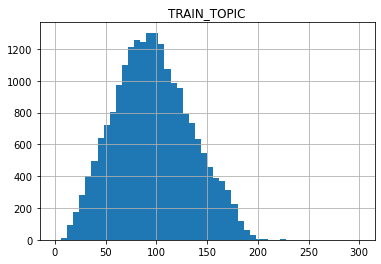

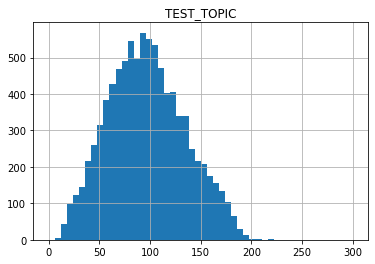

In [23]:
# Check distribution of CTOPIC from train and test dataset 

train_count,test_count = [],[]

for i in train['CTOPIC'] :
    train_count.append(len(i.split()))
    
for i in test['CTOPIC'] :
    test_count.append(len(i.split()))
    
sdf = pd.DataFrame({'TRAIN_TOPIC' : train_count})
sdf.hist(bins=50,range=(0,300))

ldf = pd.DataFrame({'TEST_TOPIC' : test_count})
ldf.hist(bins=50,range=(0,300))

In [24]:
df_topic = pd.concat([train.CTOPIC,test.CTOPIC])
df_topic =pd.DataFrame(df_topic)
df_topic.columns = ['CTOPIC']
df_topic.shape

(29961, 1)

In [25]:
df_topic

,CTOPIC
0,reconstruct subjectspecific effect map predictive model allow subjectspecific inference analyze disease relate alteration neuroimaging data give subject data inference make two level global ie identifiying condition presence subject local ie detect condition effect individual measurement extract...
1,rotation invariance neural network rotation invariance translation invariance great value image recognition task paper bring new architecture convolutional neural network cnn name cyclic convolutional layer achieve rotation invariance symbol recognition also get position orientation symbol netwo...
2,spherical polyharmonics poisson kernel polyharmonic function introduce develop notion spherical polyharmonics natural generalisation spherical harmonic particular study theory zonal polyharmonics allow u analogously zonal harmonic construct poisson kernel polyharmonic function union rotate ball ...
3,finite element approximation stochastic maxwelllandaulifshitzgilbert system stochastic landaulifshitzgilbert llg equation couple maxwell equation call stochastic mllg system describe creation domain wall vortex fundamental object novel nanostructured magnetic memory first reformulate stochastic ...
4,comparative study discrete wavelet transform wavelet tensor train decomposition feature extraction ftir data medicinal plant fouriertransform infrared ftir spectrum sample plant specie use explore influence preprocessing feature extraction efficiency machine learn algorithm wavelet tensor train ...
...,...
8984,support mixeddatatype matrix multiplication within blis framework approach problem implement mixeddatatype support within general matrix multiplication gemm operation blis framework whereby matrix operand b may store single doubleprecision real complex value another factor complexity whereby com...
8985,axiomatic basis blackwell optimality theory markov decision process mdps blackwell optimal policy policy optimal every discount factor sufficiently close one paper provide axiomatic basis blackwell optimality discretetime mdps finitely many state finitely many action
8986,genevis interactive visualization tool combine crossdiscipline datasets within genetics genevis webbased tool visualize complementary data set different discipline within field genetics overlay genecluster information geneinteraction data genedisease association data mean webbased interactive gr...
8987,quantify causal effect speed camera road traffic accident via approximate bayesian doubly robust estimator paper quantify effect speed camera road traffic collision use approximate bayesian doublyrobust dr causal inference estimation method previous empirical work topic show diverse range estima...


In [ ]:
# Covert text to numbers the CTOPICS for modelling on combined Topics of train and test

cvz = CountVectorizer(max_features = 10000,min_df = 5,max_df = 0.9)
cvz_vector = cvz.fit_transform(df_topic['CTOPIC'].values)
vocab = cvz.get_feature_names()
cvz_vector.shape,len(vocab)

In [ ]:
cvz_vector.toarray().shape

In [ ]:
X    = cvz_vector.toarray()[0:20972]
Xtst = cvz_vector.toarray()[20972:]

X.shape,Xtst.shape

In [ ]:
# Covert text to numbers the CTOPICS for modelling on combined Topics of train and test

tfidf = TfidfVectorizer(max_features = 20000,min_df = 5,max_df = 0.9)
tf_matrix = tfidf.fit_transform(df_topic['CTOPIC'].values)
vocab = tfidf.get_feature_names()
tf_matrix.shape,len(vocab)

In [ ]:
X    = tf_matrix.toarray()[0:20972]
Xtst = tf_matrix.toarray()[20972:]

X.shape,Xtst.shape

In [ ]:
X

In [ ]:
Xtst

In [26]:
# Word2Vec Model

def get_embedding_w2v(doc_tokens, pre_trained,model):
    embeddings = []
    # if pre_trained = 1; use Google's model (Glove) else use our own model (Word2Vec)
    if pre_trained:
        model = model
    else:
        model = model_cd
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        if tok in model.wv.vocab:
            embeddings.append(model.wv.word_vec(tok))
    # mean the vectors of individual words to get the vector of the statement
    return np.mean(embeddings, axis=0)

# using Word2Vec approach

# check the output of simple_preprocess on the first article
#print(simple_preprocess(train.cleaned_tweet[0])[:200])

cd_topic = df_topic.CTOPIC.apply(lambda x: simple_preprocess(x))

model_cd = Word2Vec(cd_topic,min_count=5,size = 300,sg=1)

X_W2Vec = cd_topic.apply(lambda x :  get_embedding_w2v(x,0,model_cd))

X_W2Vec = pd.DataFrame(X_W2Vec.tolist())

print('X train shape:', X_W2Vec.shape)


X train shape: (29961, 300)


In [27]:
cd_topic

0       [reconstruct, subjectspecific, effect, map, predictive, model, allow, subjectspecific, inference, analyze, disease, relate, alteration, neuroimaging, data, give, subject, data, inference, make, two, level, global, ie, identifiying, condition, presence, subject, local, ie, detect, condition, effe...
1       [rotation, invariance, neural, network, rotation, invariance, translation, invariance, great, value, image, recognition, task, paper, bring, new, architecture, convolutional, neural, network, cnn, name, cyclic, convolutional, layer, achieve, rotation, invariance, symbol, recognition, also, get, ...
2       [spherical, polyharmonics, poisson, kernel, polyharmonic, function, introduce, develop, notion, spherical, polyharmonics, natural, generalisation, spherical, harmonic, particular, study, theory, zonal, polyharmonics, allow, analogously, zonal, harmonic, construct, poisson, kernel, polyharmonic, ...
3       [finite, element, approximation, stochastic, system, stochastic, llg

In [ ]:
# use pretrained model glove

# path of the downloaded model
#glove_file = '/kaggle/input/glove-840b-300d/glove.840B.300d.txt'
#glove_file  = '/kaggle/input/glove840b300dtxt/glove.840B.300d.txt'
glove_file = '/kaggle/input/glove6b200d/glove.6B.200d.txt'
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)
# load into gensim
model = KeyedVectors.load_word2vec_format(tmp_file)

X_W2Vec = cd_topic.apply(lambda x :  get_embedding_w2v(x,1,model))

X_W2Vec = pd.DataFrame(X_W2Vec.tolist())

print('X train shape:', X_W2Vec.shape)


In [28]:
X_W2Vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.004395,-0.014429,-0.118967,0.144441,0.047146,-0.082359,-0.003433,0.041695,0.028160,-0.081983,...,-0.029333,0.107936,-0.085387,0.078530,-0.021781,-0.162576,0.030937,0.015338,-0.101510,-0.100606
1,0.019959,-0.044697,-0.127499,0.112567,0.048932,-0.157091,0.051031,-0.022847,-0.031641,-0.024711,...,-0.004675,0.174645,-0.054833,0.146336,-0.024791,-0.175313,0.110402,0.044231,-0.102927,-0.177728
2,-0.069168,-0.019877,-0.240194,-0.005484,-0.014286,-0.049032,0.036692,0.088968,-0.080871,-0.005845,...,-0.002189,0.093674,0.045371,0.103537,-0.007746,-0.165445,0.145478,0.056392,-0.183772,-0.204604
3,0.017783,0.030174,-0.203255,0.103999,-0.013799,-0.107335,0.046747,-0.019968,-0.003021,-0.022992,...,0.059907,0.149139,-0.034114,0.163085,-0.010560,-0.174835,0.085090,0.026920,-0.164469,-0.120742
4,-0.009665,-0.006123,-0.094126,0.172171,0.042418,-0.053544,0.057551,0.060735,-0.051271,-0.095096,...,-0.025602,0.165922,-0.042736,0.037016,-0.018597,-0.169570,0.016933,0.025206,-0.180061,-0.100020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29956,-0.033613,0.050624,-0.115314,0.138597,-0.030330,-0.040587,-0.009868,0.055281,-0.035970,-0.023471,...,-0.021585,0.165716,-0.075870,0.142044,-0.005140,-0.185370,0.026572,0.057292,-0.084207,-0.089447
29957,0.016677,0.053871,-0.172480,0.127602,0.003298,-0.018239,0.108875,0.026788,-0.013081,-0.068097,...,-0.029756,0.207047,-0.092035,0.096900,-0.039003,-0.220018,0.042535,0.027826,-0.158664,-0.176948
29958,0.010374,-0.038599,0.000704,0.148983,0.026289,0.012737,0.035246,0.096205,-0.033084,-0.089959,...,-0.027586,0.164941,-0.077540,0.089673,-0.072800,-0.197970,0.021088,0.029539,-0.008660,-0.143387
29959,-0.040491,0.090524,-0.170122,0.130588,0.047635,-0.148778,0.014590,-0.006381,-0.014457,-0.067722,...,-0.036289,0.087341,-0.075304,0.099612,-0.013622,-0.177850,0.040318,0.027357,-0.069291,-0.163267


In [29]:
Xtr = X_W2Vec[0:20972]
Xts = X_W2Vec[20972:]
Xtr.shape,Xts.shape

((20972, 300), (8989, 300))

In [30]:
Xtr

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.004395,-0.014429,-0.118967,0.144441,0.047146,-0.082359,-0.003433,0.041695,0.028160,-0.081983,...,-0.029333,0.107936,-0.085387,0.078530,-0.021781,-0.162576,0.030937,0.015338,-0.101510,-0.100606
1,0.019959,-0.044697,-0.127499,0.112567,0.048932,-0.157091,0.051031,-0.022847,-0.031641,-0.024711,...,-0.004675,0.174645,-0.054833,0.146336,-0.024791,-0.175313,0.110402,0.044231,-0.102927,-0.177728
2,-0.069168,-0.019877,-0.240194,-0.005484,-0.014286,-0.049032,0.036692,0.088968,-0.080871,-0.005845,...,-0.002189,0.093674,0.045371,0.103537,-0.007746,-0.165445,0.145478,0.056392,-0.183772,-0.204604
3,0.017783,0.030174,-0.203255,0.103999,-0.013799,-0.107335,0.046747,-0.019968,-0.003021,-0.022992,...,0.059907,0.149139,-0.034114,0.163085,-0.010560,-0.174835,0.085090,0.026920,-0.164469,-0.120742
4,-0.009665,-0.006123,-0.094126,0.172171,0.042418,-0.053544,0.057551,0.060735,-0.051271,-0.095096,...,-0.025602,0.165922,-0.042736,0.037016,-0.018597,-0.169570,0.016933,0.025206,-0.180061,-0.100020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20967,0.018602,-0.019023,-0.062730,0.106272,0.033092,-0.113302,0.054364,0.013217,-0.031195,-0.030267,...,-0.058356,0.114560,0.011242,0.067391,-0.037569,-0.126064,-0.020538,0.039950,-0.152378,-0.136550
20968,0.018890,0.055512,-0.101331,0.183312,-0.099120,-0.142662,-0.005527,0.080940,-0.026745,-0.012973,...,-0.003233,0.206684,-0.016783,0.125614,-0.070825,-0.107577,-0.082464,0.032451,-0.149045,-0.146551
20969,0.031605,0.012945,-0.174440,0.110298,0.065149,-0.068843,0.038881,0.031883,-0.013314,-0.059121,...,-0.057905,0.140344,-0.070827,0.102327,-0.036807,-0.151823,-0.013375,0.045356,-0.082806,-0.109161
20970,-0.067367,0.050338,-0.227238,0.134373,-0.000025,-0.087669,-0.020679,-0.035318,0.032413,-0.102630,...,-0.014339,0.095229,-0.073394,0.091252,-0.005489,-0.206819,-0.006729,-0.006182,-0.148924,-0.163257


In [31]:
Xts

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
20972,-0.019143,0.095376,-0.189997,0.165850,0.038517,-0.099492,0.006137,0.009284,0.025216,-0.086993,...,-0.031869,0.054093,-0.059776,0.085767,0.009559,-0.220269,0.031830,0.020305,-0.127945,-0.139085
20973,-0.018888,0.069592,-0.103002,0.162438,0.006207,-0.137665,-0.036916,0.099466,-0.028991,-0.011215,...,-0.091048,0.153616,-0.041259,0.129546,-0.085217,-0.134332,-0.081982,0.057149,-0.189548,-0.092060
20974,-0.000174,0.035713,-0.076805,0.158562,-0.102576,-0.017628,-0.045072,0.005387,0.039604,-0.112583,...,-0.064652,0.087609,-0.054562,0.126863,-0.001533,-0.198886,-0.005579,0.041617,0.023740,-0.209691
20975,0.064014,0.008935,-0.093940,0.166140,-0.010065,-0.173739,0.020402,0.041008,-0.016272,-0.024091,...,-0.089277,0.152607,-0.071935,0.176511,-0.090014,-0.183886,-0.146509,0.145568,-0.130428,-0.165067
20976,-0.039058,-0.016425,-0.075771,0.142462,0.026956,0.025465,-0.035483,-0.008410,0.060101,-0.094666,...,-0.034017,0.137486,0.009426,0.095096,-0.038708,-0.242759,-0.024906,0.021957,-0.054189,-0.124619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29956,-0.033613,0.050624,-0.115314,0.138597,-0.030330,-0.040587,-0.009868,0.055281,-0.035970,-0.023471,...,-0.021585,0.165716,-0.075870,0.142044,-0.005140,-0.185370,0.026572,0.057292,-0.084207,-0.089447
29957,0.016677,0.053871,-0.172480,0.127602,0.003298,-0.018239,0.108875,0.026788,-0.013081,-0.068097,...,-0.029756,0.207047,-0.092035,0.096900,-0.039003,-0.220018,0.042535,0.027826,-0.158664,-0.176948
29958,0.010374,-0.038599,0.000704,0.148983,0.026289,0.012737,0.035246,0.096205,-0.033084,-0.089959,...,-0.027586,0.164941,-0.077540,0.089673,-0.072800,-0.197970,0.021088,0.029539,-0.008660,-0.143387
29959,-0.040491,0.090524,-0.170122,0.130588,0.047635,-0.148778,0.014590,-0.006381,-0.014457,-0.067722,...,-0.036289,0.087341,-0.075304,0.099612,-0.013622,-0.177850,0.040318,0.027357,-0.069291,-0.163267


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b4ac57450>]],
      dtype=object)

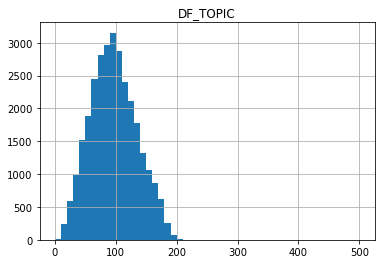

In [32]:
# Check distribution of CTOPIC from train and test dataset 

df_count = []

for i in df_topic['CTOPIC'] :
    df_count.append(len(i.split()))
    
sdf = pd.DataFrame({'DF_TOPIC' : df_count})
sdf.hist(bins=50,range=(0,500))

In [ ]:
# using pre-trained word embedding

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_topic['CTOPIC'])

df_X = tokenizer.texts_to_sequences(df_topic['CTOPIC'])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

df_X = pad_sequences(df_X, padding='post', maxlen=maxlen)
df_X.shape,vocab_size

In [ ]:
# creating the embedding here from pre-trained glove model

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

#glove_file  = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt',encoding='utf8')
glove_file = open('/kaggle/input/glove6b200d/glove.6B.200d.txt',encoding='utf8')

for line in glove_file:
  
    records = line.split()
    word = records[0]
    
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

In [ ]:
Xtr = df_X[0:20972]
Xts = df_X[20972:]
Xtr.shape,Xts.shape

In [ ]:
embedding_matrix

In [ ]:
Xtr

In [ ]:
mms = MinMaxScaler()
Xtr_scale =  mms.fit_transform(Xtr)
Xts_scale =  mms.fit_transform(Xts)

In [33]:
# create X,y for the model
y = train[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']]
X_train,X_val,y_train,y_val = train_test_split(Xtr,y,test_size =0.25,random_state=11,shuffle=True) 
#X_train,X_val,y_train,y_val = train_test_split(Xtr_scale,y,test_size =0.25,random_state=11,shuffle=True)  # scale the data
X_train.shape,X_val.shape,y_train.shape,y_val.shape,y.shape

((15729, 300), (5243, 300), (15729, 6), (5243, 6), (20972, 6))

In [34]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
9556,0.047509,0.022934,-0.141796,0.208762,-0.046574,-0.150597,0.038292,0.042590,0.041514,-0.079905,...,-0.041876,0.182098,-0.013844,0.100855,-0.020141,-0.162516,-0.043240,0.083334,-0.123980,-0.109627
18749,0.027470,0.041793,-0.264629,0.197428,0.017078,-0.122475,0.056835,-0.011526,0.008462,-0.067517,...,-0.019941,0.076385,-0.055028,0.040247,-0.029994,-0.159083,-0.024747,0.041970,-0.109228,-0.142323
19198,-0.029356,0.051337,-0.232301,0.094739,0.029076,-0.101062,-0.027789,0.068459,-0.010664,-0.031001,...,-0.083929,0.133444,-0.004829,0.095946,-0.015276,-0.169657,0.045088,0.022390,-0.191997,-0.092015
6944,-0.040335,0.041442,-0.059279,0.107495,-0.023880,-0.001203,0.068462,-0.013522,-0.036952,-0.078491,...,-0.090314,0.154045,-0.075941,0.161957,0.020027,-0.113767,0.010085,0.062910,-0.034349,-0.141857
8890,-0.009882,-0.048069,-0.121632,0.135539,0.055045,-0.089659,0.097257,0.015399,-0.046258,-0.039762,...,-0.004015,0.151659,-0.092991,0.079772,-0.017289,-0.194291,0.065314,0.025194,-0.118210,-0.147010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17677,-0.043850,0.037141,-0.099272,0.157946,-0.058784,-0.094146,-0.061300,0.027404,-0.034484,0.020062,...,-0.031878,0.172048,-0.031304,0.113716,-0.138551,-0.091814,-0.022015,0.039658,-0.177232,-0.094658
4023,-0.082534,-0.054239,-0.199603,0.085992,0.094454,-0.090254,-0.074853,0.044787,-0.033730,0.147090,...,0.094258,0.072421,-0.041711,0.179943,-0.132748,-0.208276,0.064300,-0.038271,-0.139852,-0.103029
7259,0.007846,0.006885,-0.106659,0.064423,-0.001632,-0.119388,-0.110391,0.004953,-0.063993,-0.003895,...,-0.014935,0.062201,-0.065306,0.132048,-0.035580,-0.215384,0.042179,0.013769,-0.115932,-0.122276
3775,0.008306,0.041625,-0.060615,0.128836,0.032995,-0.060086,0.015389,0.026863,-0.009751,-0.077942,...,-0.057826,0.177517,-0.079291,0.074428,0.020245,-0.145175,-0.096987,0.012977,-0.125458,-0.163932


In [35]:
y_train

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
9556,0,0,0,0,1,0
18749,0,0,0,1,0,0
19198,0,1,0,0,0,0
6944,1,0,0,0,0,0
8890,1,0,0,0,0,0
...,...,...,...,...,...,...
17677,0,1,0,0,0,0
4023,0,0,1,0,0,0
7259,0,0,1,1,0,0
3775,1,0,0,1,0,0


In [ ]:
# keras deep learning functional model / GRU & LSTM based

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False,mask_zero=True)(deep_inputs)
#embedding_layer = Embedding(vocab_size,output_dim=200, trainable=False,mask_zero=True)(deep_inputs)
Dropout_Layer_1  = Dropout(0.4)(embedding_layer)
#GRU_Layer_1 = LSTM(64,return_sequences=True)(Dropout_Layer_1)
GRU_Layer_2 = LSTM(2048)(Dropout_Layer_1)
#GRU_Layer_1 = GRU(1024)(embedding_layer)
Dropout_Layer_2  = Dropout(0.4)(GRU_Layer_2)
dense_layer_1 = Dense(6, activation='sigmoid')(Dropout_Layer_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
early_stopping = EarlyStopping(monitor ='val_loss',min_delta=0.01,patience=80,mode='min')

filepath = 'best_weighs.hdf5'
model_checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
model.summary()

In [ ]:
# keras deep learning functional model / GRU based

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False,mask_zero=True)(deep_inputs)
#embedding_layer = Embedding(vocab_size,output_dim=200, trainable=False,mask_zero=True)(deep_inputs)
Dropout_Layer_1  = Dropout(0.4)(embedding_layer)
GRU_Layer_1 = GRU(50,return_sequences=True)(Dropout_Layer_1)
GRU_Layer_2 = GRU(50)(GRU_Layer_1)
#GRU_Layer_1 = GRU(1024)(embedding_layer)
Dropout_Layer_2  = Dropout(0.4)(GRU_Layer_2)
dense_layer_1 = Dense(6, activation='sigmoid')(Dropout_Layer_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
early_stopping = EarlyStopping(monitor ='val_loss',min_delta=0.01,patience=80,mode='min')

filepath = 'best_weighs.hdf5'
model_checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
model.summary()

In [ ]:
# keras deep learning functional model / CNN based

model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=maxlen))
model.add(Conv1D(64, 1, strides=2,padding='same', activation='sigmoid'))
model.add(Conv1D(64, 1, strides=2,padding='same', activation='sigmoid'))
model.add(Conv1D(64, 1, strides=2,padding='same', activation='sigmoid'))
#model.add(MaxPooling1D(1,padding='valid'))
model.add(BatchNormalization())
model.add(Conv1D(128, 1, strides=2,padding='same', activation='sigmoid'))
model.add(Conv1D(128, 1, strides=2,padding='same', activation='sigmoid'))
model.add(Conv1D(128, 1, strides=2,padding='same', activation='sigmoid'))
#model.add(MaxPooling1D(1,padding='valid'))
#model.add(Conv1D(512, 3,  strides=2,padding='same',activation='sigmoid'))
#model.add(MaxPooling1D(1,padding='valid'))
#model.add(Dropout(0.50))
#model.add(Conv1D(48, 3, activation='sigmoid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(6))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
early_stopping = EarlyStopping(monitor ='val_loss',min_delta=0.01,patience=50,mode='min')

filepath = 'best_weighs.hdf5'
model_checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=300, verbose=1, validation_data=(X_val,y_val),callbacks=[early_stopping,model_checkpoint])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('best_weighs.hdf5')

In [ ]:
yhat = model.predict(X_val)
yhat

In [ ]:
yhat.shape

In [ ]:
def _conv01(yhat) :
    for i in range(yhat.shape[0]) :
        for j in range(0,6) :
            if yhat[i][j] >= 0.5 :
                yhat[i][j] = 1
            else :
                yhat[i][j] =0 
    return yhat

In [ ]:
yhat = _conv01(yhat)
yhat

In [ ]:
f1_score(y_val,yhat,average='weighted')

In [ ]:
pred = model.predict(Xts)
pred = _conv01(pred)
pred

In [ ]:
# Covert text to numbers the CTOPICS for modelling

cvz = CountVectorizer(max_features = 7000,min_df = 5,max_df = 0.9)
cvz_vector_train = cvz.fit_transform(train['CTOPIC'].values)
cvz_vector_test = cvz.fit_transform(test['CTOPIC'].values)
vocab_train = cvz.get_feature_names()
vocab_test  = cvz.get_feature_names()
cvz_vector_train.shape,cvz_vector_test.shape

In [ ]:
train_df.TAGS

In [ ]:
le = LabelEncoder()
train_df['TAGS'] = le.fit_transform(train_df['TAGS'])
train_df.TAGS

In [ ]:
#mlb = MultiLabelBinarizer()

#mlb.fit(train[['Computer Science', 'Physics', 'Mathematics',
#       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].values)

#y = mlb.transform(train[['Computer Science', 'Physics', 'Mathematics',
#       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].values)

y = train[['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']].values
y.shape

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(Xtr,y,test_size =0.25,random_state=11,shuffle=True) 
#X_train,X_val,y_train,y_val = train_test_split(X,y,test_size =0.25,random_state=11,shuffle=True) 
#X_train,X_val,y_train,y_val = train_test_split(cvz_vector_train,y,test_size =0.25,random_state=11,shuffle=True)  # W2Vec and glove
X_train.shape,X_val.shape,y_train.shape,y_val.shape,y.shape

In [ ]:
X_train

In [ ]:
y_train

In [36]:
lr = LogisticRegression(max_iter=1000)
clf = OneVsRestClassifier(lr)
clf.fit(X_train,y_train)
yhat = clf.predict(X_val)
f1_score(y_val,yhat,average='weighted')

0.8039458908541032

In [ ]:
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
lrrs = RandomizedSearchCV(lr, distributions, random_state=0)
search = lrrs.fit(X_train,y_train)
search.best_params_

In [ ]:
nb = MultinomialNB()
clf = OneVsRestClassifier(nb)
clf.fit(X_train,y_train)
yhat = clf.predict(X_val)
f1_score(y_val,yhat,average='weighted')

In [37]:
gb = GaussianNB()
clf = OneVsRestClassifier(gb)
clf.fit(X_train,y_train)
yhat = clf.predict(X_val)
f1_score(y_val,yhat,average='weighted')

0.7540163958037627

In [38]:
rf = RandomForestClassifier()
clf = OneVsRestClassifier(rf)
clf.fit(X_train,y_train)
yhat = clf.predict(X_val)
f1_score(y_val,yhat,average='weighted')

0.7968128868114903

In [48]:
xg = XGBClassifier(n_estimators= 1000)
clf = OneVsRestClassifier(xg)
clf.fit(X_train,y_train)
yhat = clf.predict(X_val)
f1_score(y_val,yhat,average='weighted')

KeyboardInterrupt: 

In [40]:
lg = ltb.LGBMClassifier()
clf = OneVsRestClassifier(lg)
clf.fit(X_train,y_train)
yhat = clf.predict(X_val)
f1_score(y_val,yhat,average='weighted')

0.8097360315432341

In [ ]:
# Hyper parameter tunning for LGBM

N_FOLDS = 3
MAX_BOOST_ROUNDS = 700
LEARNING_RATE = .0022

lg_train = ltb.Dataset(data=X_train, label=y_train,feature_name=list(X_train))

params = {}
params['max_bin'] = 10
params['learning_rate'] = LEARNING_RATE # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['num_classes'] = 6
#params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
#params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0


# Cross-validate
cv_lgb = ltb.cv(params, lg_train, num_boost_round=MAX_BOOST_ROUNDS, nfold=N_FOLDS, 
                    verbose_eval=20, early_stopping_rounds=40)

In [49]:
cb = ctb.CatBoostClassifier(n_estimators =2500)
clf = OneVsRestClassifier(cb)
clf.fit(X_train,y_train)
yhat = clf.predict(X_val)
f1_score(y_val,yhat,average='weighted')

Learning rate set to 0.014422
0:	learn: 0.6816236	total: 113ms	remaining: 4m 43s
1:	learn: 0.6705305	total: 228ms	remaining: 4m 44s
2:	learn: 0.6608325	total: 341ms	remaining: 4m 44s
3:	learn: 0.6501418	total: 455ms	remaining: 4m 43s
4:	learn: 0.6409495	total: 562ms	remaining: 4m 40s
5:	learn: 0.6312159	total: 671ms	remaining: 4m 39s
6:	learn: 0.6225426	total: 783ms	remaining: 4m 38s
7:	learn: 0.6136808	total: 898ms	remaining: 4m 39s
8:	learn: 0.6051327	total: 1.01s	remaining: 4m 40s
9:	learn: 0.5974963	total: 1.12s	remaining: 4m 39s
10:	learn: 0.5900916	total: 1.24s	remaining: 4m 39s
11:	learn: 0.5829771	total: 1.34s	remaining: 4m 38s
12:	learn: 0.5757610	total: 1.46s	remaining: 4m 38s
13:	learn: 0.5689197	total: 1.57s	remaining: 4m 39s
14:	learn: 0.5618984	total: 1.69s	remaining: 4m 39s
15:	learn: 0.5545576	total: 1.8s	remaining: 4m 38s
16:	learn: 0.5485350	total: 1.91s	remaining: 4m 38s
17:	learn: 0.5431178	total: 2.02s	remaining: 4m 38s
18:	learn: 0.5370145	total: 2.13s	remaining: 

157:	learn: 0.3230228	total: 17.9s	remaining: 4m 25s
158:	learn: 0.3227037	total: 18s	remaining: 4m 24s
159:	learn: 0.3223909	total: 18.1s	remaining: 4m 24s
160:	learn: 0.3220743	total: 18.2s	remaining: 4m 24s
161:	learn: 0.3217703	total: 18.3s	remaining: 4m 24s
162:	learn: 0.3214111	total: 18.4s	remaining: 4m 24s
163:	learn: 0.3210500	total: 18.5s	remaining: 4m 24s
164:	learn: 0.3206887	total: 18.6s	remaining: 4m 23s
165:	learn: 0.3203701	total: 18.8s	remaining: 4m 23s
166:	learn: 0.3199948	total: 18.9s	remaining: 4m 23s
167:	learn: 0.3196336	total: 19s	remaining: 4m 23s
168:	learn: 0.3193067	total: 19.1s	remaining: 4m 23s
169:	learn: 0.3190056	total: 19.3s	remaining: 4m 24s
170:	learn: 0.3186949	total: 19.5s	remaining: 4m 25s
171:	learn: 0.3183860	total: 19.7s	remaining: 4m 26s
172:	learn: 0.3180215	total: 19.8s	remaining: 4m 26s
173:	learn: 0.3176684	total: 20s	remaining: 4m 27s
174:	learn: 0.3172923	total: 20.1s	remaining: 4m 26s
175:	learn: 0.3169826	total: 20.2s	remaining: 4m 26s

313:	learn: 0.2891247	total: 35.5s	remaining: 4m 7s
314:	learn: 0.2890040	total: 35.6s	remaining: 4m 7s
315:	learn: 0.2888419	total: 35.7s	remaining: 4m 6s
316:	learn: 0.2887268	total: 35.8s	remaining: 4m 6s
317:	learn: 0.2885893	total: 35.9s	remaining: 4m 6s
318:	learn: 0.2884441	total: 36.1s	remaining: 4m 6s
319:	learn: 0.2883211	total: 36.2s	remaining: 4m 6s
320:	learn: 0.2882032	total: 36.3s	remaining: 4m 6s
321:	learn: 0.2880414	total: 36.4s	remaining: 4m 5s
322:	learn: 0.2879181	total: 36.5s	remaining: 4m 5s
323:	learn: 0.2877699	total: 36.6s	remaining: 4m 5s
324:	learn: 0.2876231	total: 36.7s	remaining: 4m 5s
325:	learn: 0.2874642	total: 36.8s	remaining: 4m 5s
326:	learn: 0.2873096	total: 36.9s	remaining: 4m 5s
327:	learn: 0.2871623	total: 37s	remaining: 4m 5s
328:	learn: 0.2870234	total: 37.1s	remaining: 4m 4s
329:	learn: 0.2868514	total: 37.2s	remaining: 4m 4s
330:	learn: 0.2867140	total: 37.3s	remaining: 4m 4s
331:	learn: 0.2865822	total: 37.4s	remaining: 4m 4s
332:	learn: 0.

471:	learn: 0.2697304	total: 54.1s	remaining: 3m 52s
472:	learn: 0.2696294	total: 54.2s	remaining: 3m 52s
473:	learn: 0.2695237	total: 54.4s	remaining: 3m 52s
474:	learn: 0.2694238	total: 54.5s	remaining: 3m 52s
475:	learn: 0.2693051	total: 54.6s	remaining: 3m 52s
476:	learn: 0.2692193	total: 54.7s	remaining: 3m 51s
477:	learn: 0.2690984	total: 54.8s	remaining: 3m 51s
478:	learn: 0.2689911	total: 54.9s	remaining: 3m 51s
479:	learn: 0.2688539	total: 55s	remaining: 3m 51s
480:	learn: 0.2687357	total: 55.2s	remaining: 3m 51s
481:	learn: 0.2686156	total: 55.3s	remaining: 3m 51s
482:	learn: 0.2685126	total: 55.4s	remaining: 3m 51s
483:	learn: 0.2684190	total: 55.5s	remaining: 3m 51s
484:	learn: 0.2683343	total: 55.6s	remaining: 3m 50s
485:	learn: 0.2682343	total: 55.7s	remaining: 3m 50s
486:	learn: 0.2681378	total: 55.8s	remaining: 3m 50s
487:	learn: 0.2680403	total: 55.9s	remaining: 3m 50s
488:	learn: 0.2679512	total: 56s	remaining: 3m 50s
489:	learn: 0.2678479	total: 56.2s	remaining: 3m 5

628:	learn: 0.2540364	total: 1m 11s	remaining: 3m 32s
629:	learn: 0.2539468	total: 1m 11s	remaining: 3m 32s
630:	learn: 0.2538366	total: 1m 11s	remaining: 3m 32s
631:	learn: 0.2537269	total: 1m 11s	remaining: 3m 32s
632:	learn: 0.2536239	total: 1m 11s	remaining: 3m 32s
633:	learn: 0.2534895	total: 1m 12s	remaining: 3m 32s
634:	learn: 0.2534026	total: 1m 12s	remaining: 3m 32s
635:	learn: 0.2532934	total: 1m 12s	remaining: 3m 31s
636:	learn: 0.2531810	total: 1m 12s	remaining: 3m 31s
637:	learn: 0.2530783	total: 1m 12s	remaining: 3m 31s
638:	learn: 0.2529672	total: 1m 12s	remaining: 3m 31s
639:	learn: 0.2528458	total: 1m 12s	remaining: 3m 31s
640:	learn: 0.2527398	total: 1m 12s	remaining: 3m 31s
641:	learn: 0.2525998	total: 1m 12s	remaining: 3m 31s
642:	learn: 0.2525095	total: 1m 13s	remaining: 3m 30s
643:	learn: 0.2523720	total: 1m 13s	remaining: 3m 30s
644:	learn: 0.2522433	total: 1m 13s	remaining: 3m 30s
645:	learn: 0.2521408	total: 1m 13s	remaining: 3m 30s
646:	learn: 0.2520321	total:

781:	learn: 0.2376652	total: 1m 28s	remaining: 3m 14s
782:	learn: 0.2375504	total: 1m 28s	remaining: 3m 14s
783:	learn: 0.2374130	total: 1m 28s	remaining: 3m 14s
784:	learn: 0.2373409	total: 1m 28s	remaining: 3m 14s
785:	learn: 0.2372270	total: 1m 28s	remaining: 3m 13s
786:	learn: 0.2371261	total: 1m 29s	remaining: 3m 13s
787:	learn: 0.2370284	total: 1m 29s	remaining: 3m 13s
788:	learn: 0.2369193	total: 1m 29s	remaining: 3m 13s
789:	learn: 0.2367948	total: 1m 29s	remaining: 3m 13s
790:	learn: 0.2367076	total: 1m 29s	remaining: 3m 13s
791:	learn: 0.2366167	total: 1m 29s	remaining: 3m 13s
792:	learn: 0.2365046	total: 1m 29s	remaining: 3m 12s
793:	learn: 0.2364166	total: 1m 29s	remaining: 3m 12s
794:	learn: 0.2363040	total: 1m 29s	remaining: 3m 12s
795:	learn: 0.2361629	total: 1m 29s	remaining: 3m 12s
796:	learn: 0.2360411	total: 1m 30s	remaining: 3m 12s
797:	learn: 0.2359038	total: 1m 30s	remaining: 3m 12s
798:	learn: 0.2357698	total: 1m 30s	remaining: 3m 12s
799:	learn: 0.2356536	total:

935:	learn: 0.2212365	total: 1m 44s	remaining: 2m 55s
936:	learn: 0.2211239	total: 1m 45s	remaining: 2m 55s
937:	learn: 0.2210160	total: 1m 45s	remaining: 2m 55s
938:	learn: 0.2209251	total: 1m 45s	remaining: 2m 55s
939:	learn: 0.2208305	total: 1m 45s	remaining: 2m 54s
940:	learn: 0.2207145	total: 1m 45s	remaining: 2m 54s
941:	learn: 0.2205982	total: 1m 45s	remaining: 2m 54s
942:	learn: 0.2204892	total: 1m 45s	remaining: 2m 54s
943:	learn: 0.2203802	total: 1m 46s	remaining: 2m 54s
944:	learn: 0.2202882	total: 1m 46s	remaining: 2m 55s
945:	learn: 0.2202129	total: 1m 46s	remaining: 2m 55s
946:	learn: 0.2201203	total: 1m 46s	remaining: 2m 55s
947:	learn: 0.2200299	total: 1m 46s	remaining: 2m 55s
948:	learn: 0.2199607	total: 1m 47s	remaining: 2m 55s
949:	learn: 0.2198922	total: 1m 47s	remaining: 2m 54s
950:	learn: 0.2197960	total: 1m 47s	remaining: 2m 54s
951:	learn: 0.2196908	total: 1m 47s	remaining: 2m 54s
952:	learn: 0.2195794	total: 1m 47s	remaining: 2m 54s
953:	learn: 0.2194776	total:

1088:	learn: 0.2065791	total: 2m 3s	remaining: 2m 39s
1089:	learn: 0.2064741	total: 2m 3s	remaining: 2m 39s
1090:	learn: 0.2063840	total: 2m 3s	remaining: 2m 39s
1091:	learn: 0.2062889	total: 2m 3s	remaining: 2m 39s
1092:	learn: 0.2062207	total: 2m 3s	remaining: 2m 39s
1093:	learn: 0.2061144	total: 2m 3s	remaining: 2m 38s
1094:	learn: 0.2060257	total: 2m 3s	remaining: 2m 38s
1095:	learn: 0.2059563	total: 2m 3s	remaining: 2m 38s
1096:	learn: 0.2058707	total: 2m 3s	remaining: 2m 38s
1097:	learn: 0.2057679	total: 2m 4s	remaining: 2m 38s
1098:	learn: 0.2056879	total: 2m 4s	remaining: 2m 38s
1099:	learn: 0.2055679	total: 2m 4s	remaining: 2m 38s
1100:	learn: 0.2054868	total: 2m 4s	remaining: 2m 38s
1101:	learn: 0.2054008	total: 2m 4s	remaining: 2m 37s
1102:	learn: 0.2053100	total: 2m 4s	remaining: 2m 37s
1103:	learn: 0.2052305	total: 2m 4s	remaining: 2m 37s
1104:	learn: 0.2051302	total: 2m 4s	remaining: 2m 37s
1105:	learn: 0.2050452	total: 2m 4s	remaining: 2m 37s
1106:	learn: 0.2049564	total

1240:	learn: 0.1933828	total: 2m 20s	remaining: 2m 22s
1241:	learn: 0.1932856	total: 2m 20s	remaining: 2m 21s
1242:	learn: 0.1932307	total: 2m 20s	remaining: 2m 21s
1243:	learn: 0.1931592	total: 2m 20s	remaining: 2m 21s
1244:	learn: 0.1930667	total: 2m 20s	remaining: 2m 21s
1245:	learn: 0.1929720	total: 2m 20s	remaining: 2m 21s
1246:	learn: 0.1928907	total: 2m 20s	remaining: 2m 21s
1247:	learn: 0.1928177	total: 2m 20s	remaining: 2m 21s
1248:	learn: 0.1927354	total: 2m 20s	remaining: 2m 21s
1249:	learn: 0.1926601	total: 2m 20s	remaining: 2m 20s
1250:	learn: 0.1926003	total: 2m 21s	remaining: 2m 20s
1251:	learn: 0.1925242	total: 2m 21s	remaining: 2m 20s
1252:	learn: 0.1924591	total: 2m 21s	remaining: 2m 20s
1253:	learn: 0.1923580	total: 2m 21s	remaining: 2m 20s
1254:	learn: 0.1922972	total: 2m 21s	remaining: 2m 20s
1255:	learn: 0.1922148	total: 2m 21s	remaining: 2m 20s
1256:	learn: 0.1921164	total: 2m 21s	remaining: 2m 20s
1257:	learn: 0.1920356	total: 2m 21s	remaining: 2m 20s
1258:	lear

1390:	learn: 0.1818836	total: 2m 36s	remaining: 2m 4s
1391:	learn: 0.1818240	total: 2m 36s	remaining: 2m 4s
1392:	learn: 0.1817343	total: 2m 36s	remaining: 2m 4s
1393:	learn: 0.1816374	total: 2m 36s	remaining: 2m 4s
1394:	learn: 0.1815701	total: 2m 36s	remaining: 2m 4s
1395:	learn: 0.1814993	total: 2m 36s	remaining: 2m 4s
1396:	learn: 0.1814358	total: 2m 37s	remaining: 2m 3s
1397:	learn: 0.1813797	total: 2m 37s	remaining: 2m 3s
1398:	learn: 0.1813448	total: 2m 37s	remaining: 2m 3s
1399:	learn: 0.1812742	total: 2m 37s	remaining: 2m 3s
1400:	learn: 0.1811803	total: 2m 37s	remaining: 2m 3s
1401:	learn: 0.1811064	total: 2m 37s	remaining: 2m 3s
1402:	learn: 0.1810430	total: 2m 37s	remaining: 2m 3s
1403:	learn: 0.1809901	total: 2m 37s	remaining: 2m 3s
1404:	learn: 0.1809297	total: 2m 37s	remaining: 2m 3s
1405:	learn: 0.1808672	total: 2m 37s	remaining: 2m 2s
1406:	learn: 0.1807913	total: 2m 38s	remaining: 2m 2s
1407:	learn: 0.1807282	total: 2m 38s	remaining: 2m 2s
1408:	learn: 0.1806644	total

1541:	learn: 0.1712728	total: 2m 53s	remaining: 1m 47s
1542:	learn: 0.1712207	total: 2m 53s	remaining: 1m 47s
1543:	learn: 0.1711293	total: 2m 53s	remaining: 1m 47s
1544:	learn: 0.1710526	total: 2m 53s	remaining: 1m 47s
1545:	learn: 0.1709578	total: 2m 54s	remaining: 1m 47s
1546:	learn: 0.1708810	total: 2m 54s	remaining: 1m 47s
1547:	learn: 0.1708218	total: 2m 54s	remaining: 1m 47s
1548:	learn: 0.1707326	total: 2m 54s	remaining: 1m 47s
1549:	learn: 0.1706462	total: 2m 54s	remaining: 1m 46s
1550:	learn: 0.1705943	total: 2m 54s	remaining: 1m 46s
1551:	learn: 0.1705404	total: 2m 54s	remaining: 1m 46s
1552:	learn: 0.1704899	total: 2m 54s	remaining: 1m 46s
1553:	learn: 0.1704253	total: 2m 54s	remaining: 1m 46s
1554:	learn: 0.1703590	total: 2m 54s	remaining: 1m 46s
1555:	learn: 0.1702763	total: 2m 55s	remaining: 1m 46s
1556:	learn: 0.1702085	total: 2m 55s	remaining: 1m 46s
1557:	learn: 0.1701431	total: 2m 55s	remaining: 1m 46s
1558:	learn: 0.1700837	total: 2m 55s	remaining: 1m 45s
1559:	lear

1695:	learn: 0.1610091	total: 3m 10s	remaining: 1m 30s
1696:	learn: 0.1609523	total: 3m 10s	remaining: 1m 30s
1697:	learn: 0.1609216	total: 3m 10s	remaining: 1m 30s
1698:	learn: 0.1608465	total: 3m 10s	remaining: 1m 29s
1699:	learn: 0.1607697	total: 3m 10s	remaining: 1m 29s
1700:	learn: 0.1607272	total: 3m 10s	remaining: 1m 29s
1701:	learn: 0.1606623	total: 3m 11s	remaining: 1m 29s
1702:	learn: 0.1606048	total: 3m 11s	remaining: 1m 29s
1703:	learn: 0.1605502	total: 3m 11s	remaining: 1m 29s
1704:	learn: 0.1604742	total: 3m 11s	remaining: 1m 29s
1705:	learn: 0.1603961	total: 3m 11s	remaining: 1m 29s
1706:	learn: 0.1603274	total: 3m 11s	remaining: 1m 29s
1707:	learn: 0.1602514	total: 3m 11s	remaining: 1m 28s
1708:	learn: 0.1601850	total: 3m 11s	remaining: 1m 28s
1709:	learn: 0.1601091	total: 3m 11s	remaining: 1m 28s
1710:	learn: 0.1600702	total: 3m 12s	remaining: 1m 28s
1711:	learn: 0.1600271	total: 3m 12s	remaining: 1m 28s
1712:	learn: 0.1599547	total: 3m 12s	remaining: 1m 28s
1713:	lear

1845:	learn: 0.1518196	total: 3m 26s	remaining: 1m 13s
1846:	learn: 0.1517770	total: 3m 27s	remaining: 1m 13s
1847:	learn: 0.1517416	total: 3m 27s	remaining: 1m 13s
1848:	learn: 0.1516785	total: 3m 27s	remaining: 1m 12s
1849:	learn: 0.1516121	total: 3m 27s	remaining: 1m 12s
1850:	learn: 0.1515548	total: 3m 27s	remaining: 1m 12s
1851:	learn: 0.1514880	total: 3m 27s	remaining: 1m 12s
1852:	learn: 0.1514339	total: 3m 27s	remaining: 1m 12s
1853:	learn: 0.1513858	total: 3m 27s	remaining: 1m 12s
1854:	learn: 0.1513203	total: 3m 27s	remaining: 1m 12s
1855:	learn: 0.1512665	total: 3m 28s	remaining: 1m 12s
1856:	learn: 0.1512007	total: 3m 28s	remaining: 1m 12s
1857:	learn: 0.1511275	total: 3m 28s	remaining: 1m 11s
1858:	learn: 0.1510737	total: 3m 28s	remaining: 1m 11s
1859:	learn: 0.1510190	total: 3m 28s	remaining: 1m 11s
1860:	learn: 0.1509508	total: 3m 28s	remaining: 1m 11s
1861:	learn: 0.1508895	total: 3m 28s	remaining: 1m 11s
1862:	learn: 0.1508154	total: 3m 28s	remaining: 1m 11s
1863:	lear

1999:	learn: 0.1431062	total: 3m 43s	remaining: 55.9s
2000:	learn: 0.1430403	total: 3m 43s	remaining: 55.8s
2001:	learn: 0.1429896	total: 3m 43s	remaining: 55.7s
2002:	learn: 0.1429237	total: 3m 44s	remaining: 55.6s
2003:	learn: 0.1428706	total: 3m 44s	remaining: 55.5s
2004:	learn: 0.1428151	total: 3m 44s	remaining: 55.4s
2005:	learn: 0.1427429	total: 3m 44s	remaining: 55.3s
2006:	learn: 0.1426755	total: 3m 44s	remaining: 55.1s
2007:	learn: 0.1426222	total: 3m 44s	remaining: 55s
2008:	learn: 0.1425990	total: 3m 44s	remaining: 54.9s
2009:	learn: 0.1425465	total: 3m 44s	remaining: 54.8s
2010:	learn: 0.1424948	total: 3m 44s	remaining: 54.7s
2011:	learn: 0.1424398	total: 3m 45s	remaining: 54.6s
2012:	learn: 0.1423690	total: 3m 45s	remaining: 54.5s
2013:	learn: 0.1423019	total: 3m 45s	remaining: 54.3s
2014:	learn: 0.1422585	total: 3m 45s	remaining: 54.2s
2015:	learn: 0.1422029	total: 3m 45s	remaining: 54.1s
2016:	learn: 0.1421305	total: 3m 45s	remaining: 54.1s
2017:	learn: 0.1420706	total: 

2154:	learn: 0.1349313	total: 4m 1s	remaining: 38.7s
2155:	learn: 0.1348921	total: 4m 1s	remaining: 38.6s
2156:	learn: 0.1348532	total: 4m 1s	remaining: 38.4s
2157:	learn: 0.1348011	total: 4m 1s	remaining: 38.3s
2158:	learn: 0.1347594	total: 4m 1s	remaining: 38.2s
2159:	learn: 0.1347104	total: 4m 2s	remaining: 38.1s
2160:	learn: 0.1346598	total: 4m 2s	remaining: 38s
2161:	learn: 0.1346035	total: 4m 2s	remaining: 37.9s
2162:	learn: 0.1345670	total: 4m 2s	remaining: 37.8s
2163:	learn: 0.1345190	total: 4m 2s	remaining: 37.6s
2164:	learn: 0.1344588	total: 4m 2s	remaining: 37.5s
2165:	learn: 0.1343904	total: 4m 2s	remaining: 37.4s
2166:	learn: 0.1343485	total: 4m 2s	remaining: 37.3s
2167:	learn: 0.1343012	total: 4m 2s	remaining: 37.2s
2168:	learn: 0.1342535	total: 4m 3s	remaining: 37.1s
2169:	learn: 0.1341988	total: 4m 3s	remaining: 37s
2170:	learn: 0.1341593	total: 4m 3s	remaining: 36.9s
2171:	learn: 0.1341002	total: 4m 3s	remaining: 36.7s
2172:	learn: 0.1340529	total: 4m 3s	remaining: 36.

2309:	learn: 0.1273107	total: 4m 18s	remaining: 21.3s
2310:	learn: 0.1272543	total: 4m 18s	remaining: 21.1s
2311:	learn: 0.1272092	total: 4m 18s	remaining: 21s
2312:	learn: 0.1271629	total: 4m 18s	remaining: 20.9s
2313:	learn: 0.1271015	total: 4m 18s	remaining: 20.8s
2314:	learn: 0.1270360	total: 4m 18s	remaining: 20.7s
2315:	learn: 0.1269821	total: 4m 19s	remaining: 20.6s
2316:	learn: 0.1269194	total: 4m 19s	remaining: 20.5s
2317:	learn: 0.1268844	total: 4m 19s	remaining: 20.4s
2318:	learn: 0.1268346	total: 4m 19s	remaining: 20.2s
2319:	learn: 0.1267765	total: 4m 19s	remaining: 20.1s
2320:	learn: 0.1267201	total: 4m 19s	remaining: 20s
2321:	learn: 0.1266565	total: 4m 19s	remaining: 19.9s
2322:	learn: 0.1266033	total: 4m 19s	remaining: 19.8s
2323:	learn: 0.1265484	total: 4m 19s	remaining: 19.7s
2324:	learn: 0.1265215	total: 4m 20s	remaining: 19.6s
2325:	learn: 0.1264660	total: 4m 20s	remaining: 19.5s
2326:	learn: 0.1264146	total: 4m 20s	remaining: 19.4s
2327:	learn: 0.1263630	total: 4m

2463:	learn: 0.1198766	total: 4m 35s	remaining: 4.03s
2464:	learn: 0.1198331	total: 4m 35s	remaining: 3.92s
2465:	learn: 0.1197858	total: 4m 35s	remaining: 3.8s
2466:	learn: 0.1197402	total: 4m 36s	remaining: 3.69s
2467:	learn: 0.1196877	total: 4m 36s	remaining: 3.58s
2468:	learn: 0.1196802	total: 4m 36s	remaining: 3.47s
2469:	learn: 0.1196480	total: 4m 36s	remaining: 3.36s
2470:	learn: 0.1196118	total: 4m 36s	remaining: 3.24s
2471:	learn: 0.1195505	total: 4m 36s	remaining: 3.13s
2472:	learn: 0.1195009	total: 4m 36s	remaining: 3.02s
2473:	learn: 0.1194673	total: 4m 36s	remaining: 2.91s
2474:	learn: 0.1194238	total: 4m 36s	remaining: 2.8s
2475:	learn: 0.1193732	total: 4m 36s	remaining: 2.68s
2476:	learn: 0.1193158	total: 4m 37s	remaining: 2.57s
2477:	learn: 0.1192653	total: 4m 37s	remaining: 2.46s
2478:	learn: 0.1192205	total: 4m 37s	remaining: 2.35s
2479:	learn: 0.1191665	total: 4m 37s	remaining: 2.24s
2480:	learn: 0.1191244	total: 4m 37s	remaining: 2.13s
2481:	learn: 0.1190670	total: 

120:	learn: 0.1975063	total: 15s	remaining: 4m 53s
121:	learn: 0.1970333	total: 15.1s	remaining: 4m 53s
122:	learn: 0.1962831	total: 15.2s	remaining: 4m 53s
123:	learn: 0.1956972	total: 15.3s	remaining: 4m 52s
124:	learn: 0.1952911	total: 15.4s	remaining: 4m 52s
125:	learn: 0.1947894	total: 15.5s	remaining: 4m 52s
126:	learn: 0.1943185	total: 15.6s	remaining: 4m 51s
127:	learn: 0.1938990	total: 15.7s	remaining: 4m 51s
128:	learn: 0.1933886	total: 15.8s	remaining: 4m 50s
129:	learn: 0.1929114	total: 15.9s	remaining: 4m 50s
130:	learn: 0.1924603	total: 16s	remaining: 4m 49s
131:	learn: 0.1919383	total: 16.1s	remaining: 4m 49s
132:	learn: 0.1914186	total: 16.3s	remaining: 4m 49s
133:	learn: 0.1910970	total: 16.4s	remaining: 4m 49s
134:	learn: 0.1906905	total: 16.5s	remaining: 4m 49s
135:	learn: 0.1901248	total: 16.6s	remaining: 4m 48s
136:	learn: 0.1896876	total: 16.7s	remaining: 4m 48s
137:	learn: 0.1893258	total: 16.8s	remaining: 4m 48s
138:	learn: 0.1889161	total: 16.9s	remaining: 4m 4

276:	learn: 0.1578981	total: 32.5s	remaining: 4m 20s
277:	learn: 0.1577291	total: 32.6s	remaining: 4m 20s
278:	learn: 0.1576131	total: 32.7s	remaining: 4m 20s
279:	learn: 0.1575041	total: 32.8s	remaining: 4m 20s
280:	learn: 0.1573717	total: 32.9s	remaining: 4m 20s
281:	learn: 0.1572181	total: 33s	remaining: 4m 19s
282:	learn: 0.1570771	total: 33.2s	remaining: 4m 19s
283:	learn: 0.1569364	total: 33.3s	remaining: 4m 19s
284:	learn: 0.1568187	total: 33.4s	remaining: 4m 19s
285:	learn: 0.1566838	total: 33.5s	remaining: 4m 19s
286:	learn: 0.1565294	total: 33.6s	remaining: 4m 18s
287:	learn: 0.1564239	total: 33.7s	remaining: 4m 18s
288:	learn: 0.1563163	total: 33.8s	remaining: 4m 18s
289:	learn: 0.1561870	total: 33.9s	remaining: 4m 18s
290:	learn: 0.1560634	total: 34s	remaining: 4m 18s
291:	learn: 0.1559527	total: 34.1s	remaining: 4m 17s
292:	learn: 0.1557982	total: 34.2s	remaining: 4m 17s
293:	learn: 0.1556657	total: 34.3s	remaining: 4m 17s
294:	learn: 0.1555318	total: 34.4s	remaining: 4m 1

433:	learn: 0.1405539	total: 49.9s	remaining: 3m 57s
434:	learn: 0.1404728	total: 50s	remaining: 3m 57s
435:	learn: 0.1403826	total: 50.1s	remaining: 3m 57s
436:	learn: 0.1403044	total: 50.2s	remaining: 3m 57s
437:	learn: 0.1402221	total: 50.3s	remaining: 3m 56s
438:	learn: 0.1401721	total: 50.4s	remaining: 3m 56s
439:	learn: 0.1400959	total: 50.5s	remaining: 3m 56s
440:	learn: 0.1400198	total: 50.6s	remaining: 3m 56s
441:	learn: 0.1399464	total: 50.7s	remaining: 3m 56s
442:	learn: 0.1398437	total: 50.8s	remaining: 3m 56s
443:	learn: 0.1397928	total: 50.9s	remaining: 3m 55s
444:	learn: 0.1396826	total: 51s	remaining: 3m 55s
445:	learn: 0.1396248	total: 51.1s	remaining: 3m 55s
446:	learn: 0.1395283	total: 51.3s	remaining: 3m 55s
447:	learn: 0.1393882	total: 51.4s	remaining: 3m 55s
448:	learn: 0.1393189	total: 51.5s	remaining: 3m 55s
449:	learn: 0.1392336	total: 51.6s	remaining: 3m 54s
450:	learn: 0.1391297	total: 51.7s	remaining: 3m 54s
451:	learn: 0.1390235	total: 51.8s	remaining: 3m 5

590:	learn: 0.1276879	total: 1m 7s	remaining: 3m 37s
591:	learn: 0.1276415	total: 1m 7s	remaining: 3m 37s
592:	learn: 0.1275453	total: 1m 7s	remaining: 3m 37s
593:	learn: 0.1274797	total: 1m 7s	remaining: 3m 37s
594:	learn: 0.1273946	total: 1m 8s	remaining: 3m 38s
595:	learn: 0.1273272	total: 1m 8s	remaining: 3m 38s
596:	learn: 0.1272647	total: 1m 8s	remaining: 3m 38s
597:	learn: 0.1271996	total: 1m 8s	remaining: 3m 38s
598:	learn: 0.1271210	total: 1m 8s	remaining: 3m 37s
599:	learn: 0.1270379	total: 1m 8s	remaining: 3m 37s
600:	learn: 0.1269988	total: 1m 8s	remaining: 3m 37s
601:	learn: 0.1269101	total: 1m 8s	remaining: 3m 37s
602:	learn: 0.1268539	total: 1m 9s	remaining: 3m 37s
603:	learn: 0.1267782	total: 1m 9s	remaining: 3m 37s
604:	learn: 0.1267027	total: 1m 9s	remaining: 3m 37s
605:	learn: 0.1266023	total: 1m 9s	remaining: 3m 36s
606:	learn: 0.1265536	total: 1m 9s	remaining: 3m 36s
607:	learn: 0.1264751	total: 1m 9s	remaining: 3m 36s
608:	learn: 0.1264127	total: 1m 9s	remaining: 

745:	learn: 0.1162936	total: 1m 24s	remaining: 3m 19s
746:	learn: 0.1162123	total: 1m 24s	remaining: 3m 19s
747:	learn: 0.1161401	total: 1m 25s	remaining: 3m 19s
748:	learn: 0.1160446	total: 1m 25s	remaining: 3m 19s
749:	learn: 0.1159692	total: 1m 25s	remaining: 3m 18s
750:	learn: 0.1159174	total: 1m 25s	remaining: 3m 18s
751:	learn: 0.1158584	total: 1m 25s	remaining: 3m 18s
752:	learn: 0.1157671	total: 1m 25s	remaining: 3m 18s
753:	learn: 0.1156731	total: 1m 25s	remaining: 3m 18s
754:	learn: 0.1155699	total: 1m 25s	remaining: 3m 18s
755:	learn: 0.1154760	total: 1m 25s	remaining: 3m 18s
756:	learn: 0.1153827	total: 1m 25s	remaining: 3m 17s
757:	learn: 0.1153150	total: 1m 26s	remaining: 3m 17s
758:	learn: 0.1152310	total: 1m 26s	remaining: 3m 17s
759:	learn: 0.1151411	total: 1m 26s	remaining: 3m 17s
760:	learn: 0.1150676	total: 1m 26s	remaining: 3m 17s
761:	learn: 0.1149924	total: 1m 26s	remaining: 3m 17s
762:	learn: 0.1149424	total: 1m 26s	remaining: 3m 17s
763:	learn: 0.1148432	total:

900:	learn: 0.1044309	total: 1m 42s	remaining: 3m 1s
901:	learn: 0.1043534	total: 1m 42s	remaining: 3m 1s
902:	learn: 0.1042905	total: 1m 42s	remaining: 3m 1s
903:	learn: 0.1042456	total: 1m 42s	remaining: 3m
904:	learn: 0.1041889	total: 1m 42s	remaining: 3m
905:	learn: 0.1041063	total: 1m 42s	remaining: 3m
906:	learn: 0.1040431	total: 1m 42s	remaining: 3m
907:	learn: 0.1039534	total: 1m 42s	remaining: 3m
908:	learn: 0.1038905	total: 1m 42s	remaining: 3m
909:	learn: 0.1038311	total: 1m 43s	remaining: 3m
910:	learn: 0.1037729	total: 1m 43s	remaining: 2m 59s
911:	learn: 0.1037278	total: 1m 43s	remaining: 2m 59s
912:	learn: 0.1036630	total: 1m 43s	remaining: 2m 59s
913:	learn: 0.1035847	total: 1m 43s	remaining: 2m 59s
914:	learn: 0.1035208	total: 1m 43s	remaining: 2m 59s
915:	learn: 0.1034509	total: 1m 43s	remaining: 2m 59s
916:	learn: 0.1033722	total: 1m 43s	remaining: 2m 59s
917:	learn: 0.1032998	total: 1m 43s	remaining: 2m 59s
918:	learn: 0.1031966	total: 1m 44s	remaining: 2m 58s
919:	

1052:	learn: 0.0949985	total: 1m 58s	remaining: 2m 42s
1053:	learn: 0.0949761	total: 1m 58s	remaining: 2m 42s
1054:	learn: 0.0949237	total: 1m 58s	remaining: 2m 42s
1055:	learn: 0.0948947	total: 1m 58s	remaining: 2m 42s
1056:	learn: 0.0948347	total: 1m 58s	remaining: 2m 42s
1057:	learn: 0.0947888	total: 1m 58s	remaining: 2m 41s
1058:	learn: 0.0947263	total: 1m 58s	remaining: 2m 41s
1059:	learn: 0.0946813	total: 1m 59s	remaining: 2m 41s
1060:	learn: 0.0946468	total: 1m 59s	remaining: 2m 41s
1061:	learn: 0.0946281	total: 1m 59s	remaining: 2m 41s
1062:	learn: 0.0945886	total: 1m 59s	remaining: 2m 41s
1063:	learn: 0.0945514	total: 1m 59s	remaining: 2m 41s
1064:	learn: 0.0945027	total: 1m 59s	remaining: 2m 41s
1065:	learn: 0.0944301	total: 1m 59s	remaining: 2m 40s
1066:	learn: 0.0943604	total: 1m 59s	remaining: 2m 40s
1067:	learn: 0.0942932	total: 1m 59s	remaining: 2m 40s
1068:	learn: 0.0942331	total: 1m 59s	remaining: 2m 40s
1069:	learn: 0.0941903	total: 2m	remaining: 2m 40s
1070:	learn: 0

1205:	learn: 0.0874076	total: 2m 15s	remaining: 2m 25s
1206:	learn: 0.0873481	total: 2m 16s	remaining: 2m 25s
1207:	learn: 0.0872891	total: 2m 16s	remaining: 2m 25s
1208:	learn: 0.0872406	total: 2m 16s	remaining: 2m 25s
1209:	learn: 0.0872087	total: 2m 16s	remaining: 2m 25s
1210:	learn: 0.0871156	total: 2m 16s	remaining: 2m 25s
1211:	learn: 0.0870575	total: 2m 16s	remaining: 2m 25s
1212:	learn: 0.0869806	total: 2m 16s	remaining: 2m 25s
1213:	learn: 0.0869077	total: 2m 16s	remaining: 2m 25s
1214:	learn: 0.0868707	total: 2m 17s	remaining: 2m 24s
1215:	learn: 0.0868149	total: 2m 17s	remaining: 2m 24s
1216:	learn: 0.0867663	total: 2m 17s	remaining: 2m 24s
1217:	learn: 0.0867452	total: 2m 17s	remaining: 2m 24s
1218:	learn: 0.0866875	total: 2m 17s	remaining: 2m 24s
1219:	learn: 0.0866407	total: 2m 17s	remaining: 2m 24s
1220:	learn: 0.0866019	total: 2m 17s	remaining: 2m 24s
1221:	learn: 0.0865499	total: 2m 17s	remaining: 2m 24s
1222:	learn: 0.0864857	total: 2m 17s	remaining: 2m 23s
1223:	lear

1356:	learn: 0.0801276	total: 2m 32s	remaining: 2m 8s
1357:	learn: 0.0800690	total: 2m 32s	remaining: 2m 8s
1358:	learn: 0.0800242	total: 2m 32s	remaining: 2m 7s
1359:	learn: 0.0799681	total: 2m 32s	remaining: 2m 7s
1360:	learn: 0.0799453	total: 2m 32s	remaining: 2m 7s
1361:	learn: 0.0798867	total: 2m 32s	remaining: 2m 7s
1362:	learn: 0.0798283	total: 2m 32s	remaining: 2m 7s
1363:	learn: 0.0798127	total: 2m 32s	remaining: 2m 7s
1364:	learn: 0.0797619	total: 2m 32s	remaining: 2m 7s
1365:	learn: 0.0797227	total: 2m 33s	remaining: 2m 7s
1366:	learn: 0.0796690	total: 2m 33s	remaining: 2m 6s
1367:	learn: 0.0796051	total: 2m 33s	remaining: 2m 6s
1368:	learn: 0.0795712	total: 2m 33s	remaining: 2m 6s
1369:	learn: 0.0795472	total: 2m 33s	remaining: 2m 6s
1370:	learn: 0.0794906	total: 2m 33s	remaining: 2m 6s
1371:	learn: 0.0794439	total: 2m 33s	remaining: 2m 6s
1372:	learn: 0.0794020	total: 2m 33s	remaining: 2m 6s
1373:	learn: 0.0793609	total: 2m 33s	remaining: 2m 6s
1374:	learn: 0.0793355	total

1508:	learn: 0.0736075	total: 2m 48s	remaining: 1m 50s
1509:	learn: 0.0735609	total: 2m 48s	remaining: 1m 50s
1510:	learn: 0.0735234	total: 2m 49s	remaining: 1m 50s
1511:	learn: 0.0734660	total: 2m 49s	remaining: 1m 50s
1512:	learn: 0.0734394	total: 2m 49s	remaining: 1m 50s
1513:	learn: 0.0733791	total: 2m 49s	remaining: 1m 50s
1514:	learn: 0.0733482	total: 2m 49s	remaining: 1m 50s
1515:	learn: 0.0733067	total: 2m 49s	remaining: 1m 50s
1516:	learn: 0.0732683	total: 2m 49s	remaining: 1m 49s
1517:	learn: 0.0732492	total: 2m 49s	remaining: 1m 49s
1518:	learn: 0.0731943	total: 2m 49s	remaining: 1m 49s
1519:	learn: 0.0731790	total: 2m 50s	remaining: 1m 49s
1520:	learn: 0.0731187	total: 2m 50s	remaining: 1m 49s
1521:	learn: 0.0730721	total: 2m 50s	remaining: 1m 49s
1522:	learn: 0.0730292	total: 2m 50s	remaining: 1m 49s
1523:	learn: 0.0730045	total: 2m 50s	remaining: 1m 49s
1524:	learn: 0.0729871	total: 2m 50s	remaining: 1m 49s
1525:	learn: 0.0729168	total: 2m 50s	remaining: 1m 48s
1526:	lear

1659:	learn: 0.0675738	total: 3m 5s	remaining: 1m 33s
1660:	learn: 0.0675257	total: 3m 5s	remaining: 1m 33s
1661:	learn: 0.0675076	total: 3m 5s	remaining: 1m 33s
1662:	learn: 0.0674785	total: 3m 5s	remaining: 1m 33s
1663:	learn: 0.0674183	total: 3m 5s	remaining: 1m 33s
1664:	learn: 0.0673798	total: 3m 6s	remaining: 1m 33s
1665:	learn: 0.0673730	total: 3m 6s	remaining: 1m 33s
1666:	learn: 0.0673184	total: 3m 6s	remaining: 1m 33s
1667:	learn: 0.0672867	total: 3m 6s	remaining: 1m 32s
1668:	learn: 0.0672418	total: 3m 6s	remaining: 1m 32s
1669:	learn: 0.0672015	total: 3m 6s	remaining: 1m 32s
1670:	learn: 0.0671729	total: 3m 6s	remaining: 1m 32s
1671:	learn: 0.0671402	total: 3m 6s	remaining: 1m 32s
1672:	learn: 0.0671323	total: 3m 6s	remaining: 1m 32s
1673:	learn: 0.0670985	total: 3m 7s	remaining: 1m 32s
1674:	learn: 0.0670558	total: 3m 7s	remaining: 1m 32s
1675:	learn: 0.0670080	total: 3m 7s	remaining: 1m 32s
1676:	learn: 0.0669619	total: 3m 7s	remaining: 1m 32s
1677:	learn: 0.0669398	total

1809:	learn: 0.0622484	total: 3m 22s	remaining: 1m 17s
1810:	learn: 0.0622287	total: 3m 22s	remaining: 1m 17s
1811:	learn: 0.0622033	total: 3m 22s	remaining: 1m 17s
1812:	learn: 0.0621709	total: 3m 23s	remaining: 1m 16s
1813:	learn: 0.0621317	total: 3m 23s	remaining: 1m 16s
1814:	learn: 0.0621052	total: 3m 23s	remaining: 1m 16s
1815:	learn: 0.0620787	total: 3m 23s	remaining: 1m 16s
1816:	learn: 0.0620358	total: 3m 23s	remaining: 1m 16s
1817:	learn: 0.0620202	total: 3m 23s	remaining: 1m 16s
1818:	learn: 0.0620035	total: 3m 23s	remaining: 1m 16s
1819:	learn: 0.0619826	total: 3m 23s	remaining: 1m 16s
1820:	learn: 0.0619573	total: 3m 23s	remaining: 1m 16s
1821:	learn: 0.0619476	total: 3m 23s	remaining: 1m 15s
1822:	learn: 0.0618907	total: 3m 24s	remaining: 1m 15s
1823:	learn: 0.0618741	total: 3m 24s	remaining: 1m 15s
1824:	learn: 0.0618474	total: 3m 24s	remaining: 1m 15s
1825:	learn: 0.0618151	total: 3m 24s	remaining: 1m 15s
1826:	learn: 0.0617991	total: 3m 24s	remaining: 1m 15s
1827:	lear

1961:	learn: 0.0573010	total: 3m 39s	remaining: 1m
1962:	learn: 0.0572780	total: 3m 39s	remaining: 1m
1963:	learn: 0.0572421	total: 3m 39s	remaining: 59.9s
1964:	learn: 0.0571996	total: 3m 39s	remaining: 59.8s
1965:	learn: 0.0571760	total: 3m 39s	remaining: 59.7s
1966:	learn: 0.0571443	total: 3m 39s	remaining: 59.6s
1967:	learn: 0.0571010	total: 3m 40s	remaining: 59.5s
1968:	learn: 0.0570773	total: 3m 40s	remaining: 59.4s
1969:	learn: 0.0570363	total: 3m 40s	remaining: 59.3s
1970:	learn: 0.0570069	total: 3m 40s	remaining: 59.1s
1971:	learn: 0.0569896	total: 3m 40s	remaining: 59s
1972:	learn: 0.0569585	total: 3m 40s	remaining: 58.9s
1973:	learn: 0.0569273	total: 3m 40s	remaining: 58.8s
1974:	learn: 0.0569041	total: 3m 40s	remaining: 58.7s
1975:	learn: 0.0568964	total: 3m 40s	remaining: 58.6s
1976:	learn: 0.0568677	total: 3m 40s	remaining: 58.5s
1977:	learn: 0.0568555	total: 3m 41s	remaining: 58.3s
1978:	learn: 0.0568406	total: 3m 41s	remaining: 58.2s
1979:	learn: 0.0568202	total: 3m 41s

2115:	learn: 0.0529737	total: 3m 56s	remaining: 42.9s
2116:	learn: 0.0529593	total: 3m 56s	remaining: 42.7s
2117:	learn: 0.0529152	total: 3m 56s	remaining: 42.6s
2118:	learn: 0.0528789	total: 3m 56s	remaining: 42.5s
2119:	learn: 0.0528299	total: 3m 56s	remaining: 42.4s
2120:	learn: 0.0528145	total: 3m 56s	remaining: 42.3s
2121:	learn: 0.0527924	total: 3m 56s	remaining: 42.2s
2122:	learn: 0.0527863	total: 3m 56s	remaining: 42.1s
2123:	learn: 0.0527553	total: 3m 57s	remaining: 42s
2124:	learn: 0.0527336	total: 3m 57s	remaining: 41.8s
2125:	learn: 0.0526911	total: 3m 57s	remaining: 41.7s
2126:	learn: 0.0526734	total: 3m 57s	remaining: 41.6s
2127:	learn: 0.0526421	total: 3m 57s	remaining: 41.5s
2128:	learn: 0.0526154	total: 3m 57s	remaining: 41.4s
2129:	learn: 0.0525956	total: 3m 57s	remaining: 41.3s
2130:	learn: 0.0525817	total: 3m 57s	remaining: 41.2s
2131:	learn: 0.0525622	total: 3m 57s	remaining: 41.1s
2132:	learn: 0.0525323	total: 3m 57s	remaining: 40.9s
2133:	learn: 0.0525205	total: 

2270:	learn: 0.0487453	total: 4m 14s	remaining: 25.6s
2271:	learn: 0.0487301	total: 4m 14s	remaining: 25.5s
2272:	learn: 0.0487046	total: 4m 14s	remaining: 25.4s
2273:	learn: 0.0486796	total: 4m 14s	remaining: 25.3s
2274:	learn: 0.0486593	total: 4m 14s	remaining: 25.2s
2275:	learn: 0.0486288	total: 4m 14s	remaining: 25.1s
2276:	learn: 0.0485939	total: 4m 15s	remaining: 25s
2277:	learn: 0.0485818	total: 4m 15s	remaining: 24.9s
2278:	learn: 0.0485493	total: 4m 15s	remaining: 24.8s
2279:	learn: 0.0485410	total: 4m 15s	remaining: 24.7s
2280:	learn: 0.0485247	total: 4m 15s	remaining: 24.5s
2281:	learn: 0.0485066	total: 4m 15s	remaining: 24.4s
2282:	learn: 0.0484639	total: 4m 15s	remaining: 24.3s
2283:	learn: 0.0484226	total: 4m 15s	remaining: 24.2s
2284:	learn: 0.0484067	total: 4m 16s	remaining: 24.1s
2285:	learn: 0.0483841	total: 4m 16s	remaining: 24s
2286:	learn: 0.0483522	total: 4m 16s	remaining: 23.9s
2287:	learn: 0.0483280	total: 4m 16s	remaining: 23.8s
2288:	learn: 0.0482963	total: 4m

2424:	learn: 0.0448571	total: 4m 31s	remaining: 8.38s
2425:	learn: 0.0448289	total: 4m 31s	remaining: 8.27s
2426:	learn: 0.0447893	total: 4m 31s	remaining: 8.16s
2427:	learn: 0.0447623	total: 4m 31s	remaining: 8.05s
2428:	learn: 0.0447277	total: 4m 31s	remaining: 7.94s
2429:	learn: 0.0446946	total: 4m 31s	remaining: 7.83s
2430:	learn: 0.0446652	total: 4m 31s	remaining: 7.71s
2431:	learn: 0.0446427	total: 4m 31s	remaining: 7.6s
2432:	learn: 0.0446337	total: 4m 32s	remaining: 7.49s
2433:	learn: 0.0446161	total: 4m 32s	remaining: 7.38s
2434:	learn: 0.0446056	total: 4m 32s	remaining: 7.27s
2435:	learn: 0.0445937	total: 4m 32s	remaining: 7.15s
2436:	learn: 0.0445659	total: 4m 32s	remaining: 7.04s
2437:	learn: 0.0445582	total: 4m 32s	remaining: 6.93s
2438:	learn: 0.0445494	total: 4m 32s	remaining: 6.82s
2439:	learn: 0.0445318	total: 4m 32s	remaining: 6.71s
2440:	learn: 0.0444985	total: 4m 32s	remaining: 6.59s
2441:	learn: 0.0444672	total: 4m 32s	remaining: 6.48s
2442:	learn: 0.0444316	total:

80:	learn: 0.2799643	total: 9.54s	remaining: 4m 44s
81:	learn: 0.2788477	total: 9.65s	remaining: 4m 44s
82:	learn: 0.2777039	total: 9.76s	remaining: 4m 44s
83:	learn: 0.2766717	total: 9.87s	remaining: 4m 43s
84:	learn: 0.2753445	total: 9.98s	remaining: 4m 43s
85:	learn: 0.2743371	total: 10.1s	remaining: 4m 43s
86:	learn: 0.2731834	total: 10.2s	remaining: 4m 43s
87:	learn: 0.2722707	total: 10.3s	remaining: 4m 42s
88:	learn: 0.2713562	total: 10.4s	remaining: 4m 42s
89:	learn: 0.2703875	total: 10.5s	remaining: 4m 42s
90:	learn: 0.2695036	total: 10.6s	remaining: 4m 41s
91:	learn: 0.2685561	total: 10.7s	remaining: 4m 41s
92:	learn: 0.2675161	total: 10.9s	remaining: 4m 40s
93:	learn: 0.2664930	total: 11s	remaining: 4m 40s
94:	learn: 0.2657593	total: 11.1s	remaining: 4m 40s
95:	learn: 0.2649448	total: 11.2s	remaining: 4m 40s
96:	learn: 0.2641677	total: 11.3s	remaining: 4m 39s
97:	learn: 0.2633478	total: 11.4s	remaining: 4m 39s
98:	learn: 0.2625065	total: 11.5s	remaining: 4m 39s
99:	learn: 0.2

237:	learn: 0.2157774	total: 27.7s	remaining: 4m 22s
238:	learn: 0.2156415	total: 27.8s	remaining: 4m 22s
239:	learn: 0.2154865	total: 27.9s	remaining: 4m 22s
240:	learn: 0.2153238	total: 28s	remaining: 4m 22s
241:	learn: 0.2151419	total: 28.1s	remaining: 4m 22s
242:	learn: 0.2149560	total: 28.2s	remaining: 4m 21s
243:	learn: 0.2147799	total: 28.3s	remaining: 4m 21s
244:	learn: 0.2145961	total: 28.4s	remaining: 4m 21s
245:	learn: 0.2144367	total: 28.5s	remaining: 4m 21s
246:	learn: 0.2142732	total: 28.6s	remaining: 4m 21s
247:	learn: 0.2141421	total: 28.7s	remaining: 4m 21s
248:	learn: 0.2140198	total: 28.8s	remaining: 4m 20s
249:	learn: 0.2138669	total: 29s	remaining: 4m 20s
250:	learn: 0.2136994	total: 29.1s	remaining: 4m 20s
251:	learn: 0.2135231	total: 29.2s	remaining: 4m 20s
252:	learn: 0.2133445	total: 29.3s	remaining: 4m 20s
253:	learn: 0.2131452	total: 29.4s	remaining: 4m 19s
254:	learn: 0.2130128	total: 29.5s	remaining: 4m 19s
255:	learn: 0.2128651	total: 29.8s	remaining: 4m 2

393:	learn: 0.1956908	total: 45.9s	remaining: 4m 5s
394:	learn: 0.1955832	total: 46s	remaining: 4m 5s
395:	learn: 0.1954838	total: 46.1s	remaining: 4m 4s
396:	learn: 0.1953848	total: 46.2s	remaining: 4m 4s
397:	learn: 0.1952839	total: 46.3s	remaining: 4m 4s
398:	learn: 0.1951434	total: 46.4s	remaining: 4m 4s
399:	learn: 0.1950045	total: 46.5s	remaining: 4m 4s
400:	learn: 0.1949007	total: 46.6s	remaining: 4m 4s
401:	learn: 0.1948100	total: 46.7s	remaining: 4m 3s
402:	learn: 0.1946749	total: 46.8s	remaining: 4m 3s
403:	learn: 0.1945779	total: 47s	remaining: 4m 3s
404:	learn: 0.1944982	total: 47.1s	remaining: 4m 3s
405:	learn: 0.1944002	total: 47.2s	remaining: 4m 3s
406:	learn: 0.1943152	total: 47.3s	remaining: 4m 3s
407:	learn: 0.1942063	total: 47.4s	remaining: 4m 2s
408:	learn: 0.1940566	total: 47.5s	remaining: 4m 2s
409:	learn: 0.1939365	total: 47.6s	remaining: 4m 2s
410:	learn: 0.1938248	total: 47.7s	remaining: 4m 2s
411:	learn: 0.1937211	total: 47.8s	remaining: 4m 2s
412:	learn: 0.19

550:	learn: 0.1811329	total: 1m 3s	remaining: 3m 45s
551:	learn: 0.1810538	total: 1m 3s	remaining: 3m 44s
552:	learn: 0.1809470	total: 1m 3s	remaining: 3m 44s
553:	learn: 0.1808529	total: 1m 3s	remaining: 3m 44s
554:	learn: 0.1807538	total: 1m 4s	remaining: 3m 44s
555:	learn: 0.1806849	total: 1m 4s	remaining: 3m 44s
556:	learn: 0.1806108	total: 1m 4s	remaining: 3m 44s
557:	learn: 0.1804998	total: 1m 4s	remaining: 3m 44s
558:	learn: 0.1804209	total: 1m 4s	remaining: 3m 44s
559:	learn: 0.1803383	total: 1m 4s	remaining: 3m 43s
560:	learn: 0.1802483	total: 1m 4s	remaining: 3m 43s
561:	learn: 0.1801385	total: 1m 4s	remaining: 3m 43s
562:	learn: 0.1800804	total: 1m 4s	remaining: 3m 43s
563:	learn: 0.1799923	total: 1m 5s	remaining: 3m 43s
564:	learn: 0.1799017	total: 1m 5s	remaining: 3m 43s
565:	learn: 0.1798250	total: 1m 5s	remaining: 3m 43s
566:	learn: 0.1797870	total: 1m 5s	remaining: 3m 42s
567:	learn: 0.1796995	total: 1m 5s	remaining: 3m 42s
568:	learn: 0.1795920	total: 1m 5s	remaining: 

703:	learn: 0.1684239	total: 1m 20s	remaining: 3m 24s
704:	learn: 0.1683337	total: 1m 20s	remaining: 3m 24s
705:	learn: 0.1682674	total: 1m 20s	remaining: 3m 24s
706:	learn: 0.1681810	total: 1m 20s	remaining: 3m 24s
707:	learn: 0.1680693	total: 1m 20s	remaining: 3m 24s
708:	learn: 0.1679796	total: 1m 20s	remaining: 3m 23s
709:	learn: 0.1678777	total: 1m 20s	remaining: 3m 23s
710:	learn: 0.1677917	total: 1m 20s	remaining: 3m 23s
711:	learn: 0.1676948	total: 1m 21s	remaining: 3m 23s
712:	learn: 0.1675613	total: 1m 21s	remaining: 3m 23s
713:	learn: 0.1674467	total: 1m 21s	remaining: 3m 23s
714:	learn: 0.1673703	total: 1m 21s	remaining: 3m 23s
715:	learn: 0.1672800	total: 1m 21s	remaining: 3m 23s
716:	learn: 0.1672003	total: 1m 21s	remaining: 3m 22s
717:	learn: 0.1671329	total: 1m 21s	remaining: 3m 22s
718:	learn: 0.1670543	total: 1m 21s	remaining: 3m 22s
719:	learn: 0.1669390	total: 1m 21s	remaining: 3m 22s
720:	learn: 0.1668527	total: 1m 21s	remaining: 3m 22s
721:	learn: 0.1667500	total:

856:	learn: 0.1552936	total: 1m 38s	remaining: 3m 8s
857:	learn: 0.1552087	total: 1m 38s	remaining: 3m 8s
858:	learn: 0.1551015	total: 1m 38s	remaining: 3m 8s
859:	learn: 0.1550096	total: 1m 38s	remaining: 3m 7s
860:	learn: 0.1549316	total: 1m 38s	remaining: 3m 7s
861:	learn: 0.1548504	total: 1m 38s	remaining: 3m 7s
862:	learn: 0.1547881	total: 1m 38s	remaining: 3m 7s
863:	learn: 0.1547116	total: 1m 38s	remaining: 3m 7s
864:	learn: 0.1546089	total: 1m 39s	remaining: 3m 7s
865:	learn: 0.1545270	total: 1m 39s	remaining: 3m 7s
866:	learn: 0.1544578	total: 1m 39s	remaining: 3m 7s
867:	learn: 0.1543571	total: 1m 39s	remaining: 3m 6s
868:	learn: 0.1542802	total: 1m 39s	remaining: 3m 6s
869:	learn: 0.1541869	total: 1m 39s	remaining: 3m 6s
870:	learn: 0.1541014	total: 1m 39s	remaining: 3m 6s
871:	learn: 0.1540205	total: 1m 39s	remaining: 3m 6s
872:	learn: 0.1539495	total: 1m 39s	remaining: 3m 6s
873:	learn: 0.1538586	total: 1m 40s	remaining: 3m 6s
874:	learn: 0.1537615	total: 1m 40s	remaining:

1010:	learn: 0.1433244	total: 1m 54s	remaining: 2m 48s
1011:	learn: 0.1432622	total: 1m 54s	remaining: 2m 48s
1012:	learn: 0.1432080	total: 1m 54s	remaining: 2m 48s
1013:	learn: 0.1431133	total: 1m 54s	remaining: 2m 48s
1014:	learn: 0.1430513	total: 1m 55s	remaining: 2m 48s
1015:	learn: 0.1429778	total: 1m 55s	remaining: 2m 48s
1016:	learn: 0.1429160	total: 1m 55s	remaining: 2m 48s
1017:	learn: 0.1428447	total: 1m 55s	remaining: 2m 48s
1018:	learn: 0.1427726	total: 1m 55s	remaining: 2m 47s
1019:	learn: 0.1427114	total: 1m 55s	remaining: 2m 47s
1020:	learn: 0.1426055	total: 1m 55s	remaining: 2m 47s
1021:	learn: 0.1425259	total: 1m 55s	remaining: 2m 47s
1022:	learn: 0.1424748	total: 1m 55s	remaining: 2m 47s
1023:	learn: 0.1423881	total: 1m 56s	remaining: 2m 47s
1024:	learn: 0.1423370	total: 1m 56s	remaining: 2m 47s
1025:	learn: 0.1423010	total: 1m 56s	remaining: 2m 46s
1026:	learn: 0.1422157	total: 1m 56s	remaining: 2m 46s
1027:	learn: 0.1421305	total: 1m 56s	remaining: 2m 46s
1028:	lear

1162:	learn: 0.1326540	total: 2m 11s	remaining: 2m 31s
1163:	learn: 0.1325803	total: 2m 11s	remaining: 2m 31s
1164:	learn: 0.1325128	total: 2m 11s	remaining: 2m 30s
1165:	learn: 0.1324364	total: 2m 11s	remaining: 2m 30s
1166:	learn: 0.1323698	total: 2m 11s	remaining: 2m 30s
1167:	learn: 0.1322887	total: 2m 12s	remaining: 2m 30s
1168:	learn: 0.1322108	total: 2m 12s	remaining: 2m 30s
1169:	learn: 0.1321488	total: 2m 12s	remaining: 2m 30s
1170:	learn: 0.1320803	total: 2m 12s	remaining: 2m 30s
1171:	learn: 0.1320097	total: 2m 12s	remaining: 2m 30s
1172:	learn: 0.1319406	total: 2m 12s	remaining: 2m 29s
1173:	learn: 0.1318730	total: 2m 12s	remaining: 2m 29s
1174:	learn: 0.1318260	total: 2m 12s	remaining: 2m 29s
1175:	learn: 0.1317617	total: 2m 12s	remaining: 2m 29s
1176:	learn: 0.1316753	total: 2m 12s	remaining: 2m 29s
1177:	learn: 0.1315894	total: 2m 13s	remaining: 2m 29s
1178:	learn: 0.1315114	total: 2m 13s	remaining: 2m 29s
1179:	learn: 0.1314225	total: 2m 13s	remaining: 2m 29s
1180:	lear

1313:	learn: 0.1227997	total: 2m 28s	remaining: 2m 13s
1314:	learn: 0.1227075	total: 2m 28s	remaining: 2m 13s
1315:	learn: 0.1226386	total: 2m 28s	remaining: 2m 13s
1316:	learn: 0.1225710	total: 2m 28s	remaining: 2m 13s
1317:	learn: 0.1224957	total: 2m 28s	remaining: 2m 13s
1318:	learn: 0.1224204	total: 2m 28s	remaining: 2m 13s
1319:	learn: 0.1223370	total: 2m 28s	remaining: 2m 13s
1320:	learn: 0.1222674	total: 2m 29s	remaining: 2m 13s
1321:	learn: 0.1221984	total: 2m 29s	remaining: 2m 12s
1322:	learn: 0.1221317	total: 2m 29s	remaining: 2m 12s
1323:	learn: 0.1220889	total: 2m 29s	remaining: 2m 12s
1324:	learn: 0.1220309	total: 2m 29s	remaining: 2m 12s
1325:	learn: 0.1219879	total: 2m 29s	remaining: 2m 12s
1326:	learn: 0.1219284	total: 2m 29s	remaining: 2m 12s
1327:	learn: 0.1218560	total: 2m 30s	remaining: 2m 12s
1328:	learn: 0.1218030	total: 2m 30s	remaining: 2m 12s
1329:	learn: 0.1217168	total: 2m 30s	remaining: 2m 12s
1330:	learn: 0.1216706	total: 2m 30s	remaining: 2m 12s
1331:	lear

1464:	learn: 0.1139024	total: 2m 45s	remaining: 1m 57s
1465:	learn: 0.1138397	total: 2m 45s	remaining: 1m 56s
1466:	learn: 0.1137711	total: 2m 45s	remaining: 1m 56s
1467:	learn: 0.1137127	total: 2m 46s	remaining: 1m 56s
1468:	learn: 0.1136645	total: 2m 46s	remaining: 1m 56s
1469:	learn: 0.1135758	total: 2m 46s	remaining: 1m 56s
1470:	learn: 0.1135517	total: 2m 46s	remaining: 1m 56s
1471:	learn: 0.1134919	total: 2m 46s	remaining: 1m 56s
1472:	learn: 0.1134214	total: 2m 46s	remaining: 1m 56s
1473:	learn: 0.1134048	total: 2m 46s	remaining: 1m 56s
1474:	learn: 0.1133746	total: 2m 46s	remaining: 1m 55s
1475:	learn: 0.1133016	total: 2m 46s	remaining: 1m 55s
1476:	learn: 0.1132407	total: 2m 46s	remaining: 1m 55s
1477:	learn: 0.1131822	total: 2m 47s	remaining: 1m 55s
1478:	learn: 0.1131089	total: 2m 47s	remaining: 1m 55s
1479:	learn: 0.1130553	total: 2m 47s	remaining: 1m 55s
1480:	learn: 0.1129957	total: 2m 47s	remaining: 1m 55s
1481:	learn: 0.1129449	total: 2m 47s	remaining: 1m 55s
1482:	lear

1615:	learn: 0.1057692	total: 3m 2s	remaining: 1m 39s
1616:	learn: 0.1057213	total: 3m 2s	remaining: 1m 39s
1617:	learn: 0.1056699	total: 3m 2s	remaining: 1m 39s
1618:	learn: 0.1056055	total: 3m 2s	remaining: 1m 39s
1619:	learn: 0.1055505	total: 3m 2s	remaining: 1m 39s
1620:	learn: 0.1055102	total: 3m 2s	remaining: 1m 39s
1621:	learn: 0.1054589	total: 3m 3s	remaining: 1m 39s
1622:	learn: 0.1053948	total: 3m 3s	remaining: 1m 39s
1623:	learn: 0.1053590	total: 3m 3s	remaining: 1m 38s
1624:	learn: 0.1053039	total: 3m 3s	remaining: 1m 38s
1625:	learn: 0.1052490	total: 3m 3s	remaining: 1m 38s
1626:	learn: 0.1052294	total: 3m 3s	remaining: 1m 38s
1627:	learn: 0.1051750	total: 3m 3s	remaining: 1m 38s
1628:	learn: 0.1051252	total: 3m 3s	remaining: 1m 38s
1629:	learn: 0.1050732	total: 3m 3s	remaining: 1m 38s
1630:	learn: 0.1050377	total: 3m 4s	remaining: 1m 38s
1631:	learn: 0.1049664	total: 3m 4s	remaining: 1m 37s
1632:	learn: 0.1049049	total: 3m 4s	remaining: 1m 37s
1633:	learn: 0.1048417	total

1767:	learn: 0.0980633	total: 3m 19s	remaining: 1m 22s
1768:	learn: 0.0980266	total: 3m 19s	remaining: 1m 22s
1769:	learn: 0.0979670	total: 3m 19s	remaining: 1m 22s
1770:	learn: 0.0979043	total: 3m 19s	remaining: 1m 22s
1771:	learn: 0.0978620	total: 3m 19s	remaining: 1m 21s
1772:	learn: 0.0978310	total: 3m 19s	remaining: 1m 21s
1773:	learn: 0.0977840	total: 3m 19s	remaining: 1m 21s
1774:	learn: 0.0977361	total: 3m 19s	remaining: 1m 21s
1775:	learn: 0.0976824	total: 3m 19s	remaining: 1m 21s
1776:	learn: 0.0976400	total: 3m 20s	remaining: 1m 21s
1777:	learn: 0.0976058	total: 3m 20s	remaining: 1m 21s
1778:	learn: 0.0975573	total: 3m 20s	remaining: 1m 21s
1779:	learn: 0.0975218	total: 3m 20s	remaining: 1m 21s
1780:	learn: 0.0974682	total: 3m 20s	remaining: 1m 20s
1781:	learn: 0.0974272	total: 3m 20s	remaining: 1m 20s
1782:	learn: 0.0973829	total: 3m 20s	remaining: 1m 20s
1783:	learn: 0.0973145	total: 3m 20s	remaining: 1m 20s
1784:	learn: 0.0972656	total: 3m 20s	remaining: 1m 20s
1785:	lear

1918:	learn: 0.0911091	total: 3m 36s	remaining: 1m 5s
1919:	learn: 0.0910710	total: 3m 36s	remaining: 1m 5s
1920:	learn: 0.0910067	total: 3m 37s	remaining: 1m 5s
1921:	learn: 0.0909772	total: 3m 37s	remaining: 1m 5s
1922:	learn: 0.0909210	total: 3m 37s	remaining: 1m 5s
1923:	learn: 0.0908866	total: 3m 37s	remaining: 1m 5s
1924:	learn: 0.0908408	total: 3m 37s	remaining: 1m 4s
1925:	learn: 0.0908068	total: 3m 37s	remaining: 1m 4s
1926:	learn: 0.0907629	total: 3m 37s	remaining: 1m 4s
1927:	learn: 0.0907052	total: 3m 37s	remaining: 1m 4s
1928:	learn: 0.0906748	total: 3m 37s	remaining: 1m 4s
1929:	learn: 0.0906173	total: 3m 38s	remaining: 1m 4s
1930:	learn: 0.0905851	total: 3m 38s	remaining: 1m 4s
1931:	learn: 0.0905415	total: 3m 38s	remaining: 1m 4s
1932:	learn: 0.0904891	total: 3m 38s	remaining: 1m 4s
1933:	learn: 0.0904657	total: 3m 38s	remaining: 1m 3s
1934:	learn: 0.0904296	total: 3m 38s	remaining: 1m 3s
1935:	learn: 0.0903829	total: 3m 38s	remaining: 1m 3s
1936:	learn: 0.0903419	total

2072:	learn: 0.0846335	total: 3m 53s	remaining: 48.2s
2073:	learn: 0.0846105	total: 3m 53s	remaining: 48s
2074:	learn: 0.0845676	total: 3m 54s	remaining: 47.9s
2075:	learn: 0.0845201	total: 3m 54s	remaining: 47.8s
2076:	learn: 0.0844730	total: 3m 54s	remaining: 47.7s
2077:	learn: 0.0844218	total: 3m 54s	remaining: 47.6s
2078:	learn: 0.0843906	total: 3m 54s	remaining: 47.5s
2079:	learn: 0.0843346	total: 3m 54s	remaining: 47.4s
2080:	learn: 0.0843180	total: 3m 54s	remaining: 47.2s
2081:	learn: 0.0842589	total: 3m 54s	remaining: 47.1s
2082:	learn: 0.0842083	total: 3m 54s	remaining: 47s
2083:	learn: 0.0841656	total: 3m 54s	remaining: 46.9s
2084:	learn: 0.0841279	total: 3m 55s	remaining: 46.8s
2085:	learn: 0.0840853	total: 3m 55s	remaining: 46.7s
2086:	learn: 0.0840477	total: 3m 55s	remaining: 46.6s
2087:	learn: 0.0839979	total: 3m 55s	remaining: 46.5s
2088:	learn: 0.0839533	total: 3m 55s	remaining: 46.3s
2089:	learn: 0.0839161	total: 3m 55s	remaining: 46.2s
2090:	learn: 0.0838753	total: 3m

2227:	learn: 0.0789081	total: 4m 10s	remaining: 30.6s
2228:	learn: 0.0788614	total: 4m 11s	remaining: 30.5s
2229:	learn: 0.0788169	total: 4m 11s	remaining: 30.4s
2230:	learn: 0.0787843	total: 4m 11s	remaining: 30.3s
2231:	learn: 0.0787490	total: 4m 11s	remaining: 30.2s
2232:	learn: 0.0787328	total: 4m 11s	remaining: 30.1s
2233:	learn: 0.0787065	total: 4m 11s	remaining: 30s
2234:	learn: 0.0786662	total: 4m 11s	remaining: 29.8s
2235:	learn: 0.0786556	total: 4m 11s	remaining: 29.7s
2236:	learn: 0.0786256	total: 4m 11s	remaining: 29.6s
2237:	learn: 0.0785783	total: 4m 11s	remaining: 29.5s
2238:	learn: 0.0785406	total: 4m 12s	remaining: 29.4s
2239:	learn: 0.0785195	total: 4m 12s	remaining: 29.3s
2240:	learn: 0.0784715	total: 4m 12s	remaining: 29.2s
2241:	learn: 0.0784224	total: 4m 12s	remaining: 29s
2242:	learn: 0.0783783	total: 4m 12s	remaining: 28.9s
2243:	learn: 0.0783278	total: 4m 12s	remaining: 28.8s
2244:	learn: 0.0783013	total: 4m 12s	remaining: 28.7s
2245:	learn: 0.0782564	total: 4m

2381:	learn: 0.0734067	total: 4m 28s	remaining: 13.3s
2382:	learn: 0.0733614	total: 4m 28s	remaining: 13.2s
2383:	learn: 0.0733483	total: 4m 28s	remaining: 13.1s
2384:	learn: 0.0733051	total: 4m 28s	remaining: 12.9s
2385:	learn: 0.0732865	total: 4m 28s	remaining: 12.8s
2386:	learn: 0.0732514	total: 4m 28s	remaining: 12.7s
2387:	learn: 0.0732028	total: 4m 28s	remaining: 12.6s
2388:	learn: 0.0731965	total: 4m 28s	remaining: 12.5s
2389:	learn: 0.0731622	total: 4m 29s	remaining: 12.4s
2390:	learn: 0.0731406	total: 4m 29s	remaining: 12.3s
2391:	learn: 0.0731182	total: 4m 29s	remaining: 12.2s
2392:	learn: 0.0730812	total: 4m 29s	remaining: 12.1s
2393:	learn: 0.0730407	total: 4m 29s	remaining: 11.9s
2394:	learn: 0.0729930	total: 4m 29s	remaining: 11.8s
2395:	learn: 0.0729626	total: 4m 30s	remaining: 11.7s
2396:	learn: 0.0729272	total: 4m 30s	remaining: 11.6s
2397:	learn: 0.0728956	total: 4m 30s	remaining: 11.5s
2398:	learn: 0.0728555	total: 4m 30s	remaining: 11.4s
2399:	learn: 0.0728130	total

36:	learn: 0.3977314	total: 4.43s	remaining: 4m 54s
37:	learn: 0.3942088	total: 4.54s	remaining: 4m 53s
38:	learn: 0.3907563	total: 4.65s	remaining: 4m 53s
39:	learn: 0.3877676	total: 4.76s	remaining: 4m 52s
40:	learn: 0.3847463	total: 4.92s	remaining: 4m 54s
41:	learn: 0.3816975	total: 5.04s	remaining: 4m 55s
42:	learn: 0.3788834	total: 5.16s	remaining: 4m 54s
43:	learn: 0.3759259	total: 5.27s	remaining: 4m 54s
44:	learn: 0.3730709	total: 5.38s	remaining: 4m 53s
45:	learn: 0.3705232	total: 5.49s	remaining: 4m 52s
46:	learn: 0.3680108	total: 5.61s	remaining: 4m 52s
47:	learn: 0.3654062	total: 5.72s	remaining: 4m 52s
48:	learn: 0.3632293	total: 5.83s	remaining: 4m 51s
49:	learn: 0.3608879	total: 5.94s	remaining: 4m 51s
50:	learn: 0.3585090	total: 6.06s	remaining: 4m 50s
51:	learn: 0.3563065	total: 6.17s	remaining: 4m 50s
52:	learn: 0.3546582	total: 6.28s	remaining: 4m 49s
53:	learn: 0.3527711	total: 6.39s	remaining: 4m 49s
54:	learn: 0.3508229	total: 6.51s	remaining: 4m 49s
55:	learn: 0

193:	learn: 0.2586982	total: 22.8s	remaining: 4m 31s
194:	learn: 0.2585046	total: 22.9s	remaining: 4m 31s
195:	learn: 0.2583064	total: 23s	remaining: 4m 30s
196:	learn: 0.2580474	total: 23.1s	remaining: 4m 30s
197:	learn: 0.2578213	total: 23.3s	remaining: 4m 30s
198:	learn: 0.2575516	total: 23.4s	remaining: 4m 30s
199:	learn: 0.2572900	total: 23.5s	remaining: 4m 29s
200:	learn: 0.2570367	total: 23.6s	remaining: 4m 29s
201:	learn: 0.2567880	total: 23.7s	remaining: 4m 29s
202:	learn: 0.2565609	total: 23.8s	remaining: 4m 29s
203:	learn: 0.2562805	total: 23.9s	remaining: 4m 29s
204:	learn: 0.2560560	total: 24s	remaining: 4m 28s
205:	learn: 0.2558909	total: 24.1s	remaining: 4m 28s
206:	learn: 0.2556841	total: 24.2s	remaining: 4m 28s
207:	learn: 0.2554779	total: 24.4s	remaining: 4m 28s
208:	learn: 0.2552042	total: 24.5s	remaining: 4m 28s
209:	learn: 0.2549705	total: 24.6s	remaining: 4m 27s
210:	learn: 0.2548129	total: 24.7s	remaining: 4m 27s
211:	learn: 0.2546140	total: 24.8s	remaining: 4m 2

349:	learn: 0.2333542	total: 40.3s	remaining: 4m 7s
350:	learn: 0.2332670	total: 40.4s	remaining: 4m 7s
351:	learn: 0.2331107	total: 40.5s	remaining: 4m 7s
352:	learn: 0.2329909	total: 40.6s	remaining: 4m 7s
353:	learn: 0.2328808	total: 40.7s	remaining: 4m 7s
354:	learn: 0.2327448	total: 40.9s	remaining: 4m 6s
355:	learn: 0.2326417	total: 41s	remaining: 4m 6s
356:	learn: 0.2325223	total: 41.1s	remaining: 4m 6s
357:	learn: 0.2324111	total: 41.2s	remaining: 4m 6s
358:	learn: 0.2322634	total: 41.3s	remaining: 4m 6s
359:	learn: 0.2320965	total: 41.4s	remaining: 4m 6s
360:	learn: 0.2319652	total: 41.7s	remaining: 4m 7s
361:	learn: 0.2318425	total: 41.9s	remaining: 4m 7s
362:	learn: 0.2317099	total: 42.1s	remaining: 4m 7s
363:	learn: 0.2316220	total: 42.3s	remaining: 4m 8s
364:	learn: 0.2315106	total: 42.4s	remaining: 4m 7s
365:	learn: 0.2313973	total: 42.5s	remaining: 4m 7s
366:	learn: 0.2313015	total: 42.6s	remaining: 4m 7s
367:	learn: 0.2312157	total: 42.7s	remaining: 4m 7s
368:	learn: 0.

508:	learn: 0.2165793	total: 59.4s	remaining: 3m 52s
509:	learn: 0.2164816	total: 59.5s	remaining: 3m 52s
510:	learn: 0.2163928	total: 59.6s	remaining: 3m 52s
511:	learn: 0.2162731	total: 59.8s	remaining: 3m 52s
512:	learn: 0.2161890	total: 59.9s	remaining: 3m 51s
513:	learn: 0.2160977	total: 60s	remaining: 3m 51s
514:	learn: 0.2160054	total: 1m	remaining: 3m 51s
515:	learn: 0.2159102	total: 1m	remaining: 3m 51s
516:	learn: 0.2158098	total: 1m	remaining: 3m 51s
517:	learn: 0.2156826	total: 1m	remaining: 3m 51s
518:	learn: 0.2155938	total: 1m	remaining: 3m 50s
519:	learn: 0.2154985	total: 1m	remaining: 3m 50s
520:	learn: 0.2153958	total: 1m	remaining: 3m 50s
521:	learn: 0.2152761	total: 1m	remaining: 3m 50s
522:	learn: 0.2151954	total: 1m	remaining: 3m 50s
523:	learn: 0.2150849	total: 1m 1s	remaining: 3m 50s
524:	learn: 0.2149879	total: 1m 1s	remaining: 3m 50s
525:	learn: 0.2149123	total: 1m 1s	remaining: 3m 49s
526:	learn: 0.2148164	total: 1m 1s	remaining: 3m 49s
527:	learn: 0.2147530	

662:	learn: 0.2027964	total: 1m 16s	remaining: 3m 32s
663:	learn: 0.2027010	total: 1m 16s	remaining: 3m 32s
664:	learn: 0.2026346	total: 1m 16s	remaining: 3m 32s
665:	learn: 0.2025569	total: 1m 16s	remaining: 3m 31s
666:	learn: 0.2024802	total: 1m 17s	remaining: 3m 31s
667:	learn: 0.2024135	total: 1m 17s	remaining: 3m 31s
668:	learn: 0.2023148	total: 1m 17s	remaining: 3m 31s
669:	learn: 0.2021955	total: 1m 17s	remaining: 3m 31s
670:	learn: 0.2021163	total: 1m 17s	remaining: 3m 31s
671:	learn: 0.2019948	total: 1m 17s	remaining: 3m 31s
672:	learn: 0.2019090	total: 1m 17s	remaining: 3m 30s
673:	learn: 0.2018305	total: 1m 17s	remaining: 3m 30s
674:	learn: 0.2017206	total: 1m 17s	remaining: 3m 30s
675:	learn: 0.2016572	total: 1m 18s	remaining: 3m 30s
676:	learn: 0.2015411	total: 1m 18s	remaining: 3m 30s
677:	learn: 0.2014647	total: 1m 18s	remaining: 3m 30s
678:	learn: 0.2013896	total: 1m 18s	remaining: 3m 30s
679:	learn: 0.2012816	total: 1m 18s	remaining: 3m 29s
680:	learn: 0.2012117	total:

815:	learn: 0.1888415	total: 1m 33s	remaining: 3m 12s
816:	learn: 0.1887471	total: 1m 33s	remaining: 3m 12s
817:	learn: 0.1886737	total: 1m 33s	remaining: 3m 12s
818:	learn: 0.1885550	total: 1m 33s	remaining: 3m 11s
819:	learn: 0.1884752	total: 1m 33s	remaining: 3m 11s
820:	learn: 0.1883980	total: 1m 33s	remaining: 3m 11s
821:	learn: 0.1882940	total: 1m 33s	remaining: 3m 11s
822:	learn: 0.1882058	total: 1m 33s	remaining: 3m 11s
823:	learn: 0.1881116	total: 1m 34s	remaining: 3m 11s
824:	learn: 0.1880128	total: 1m 34s	remaining: 3m 11s
825:	learn: 0.1879407	total: 1m 34s	remaining: 3m 10s
826:	learn: 0.1878455	total: 1m 34s	remaining: 3m 10s
827:	learn: 0.1877658	total: 1m 34s	remaining: 3m 10s
828:	learn: 0.1876932	total: 1m 34s	remaining: 3m 10s
829:	learn: 0.1875817	total: 1m 34s	remaining: 3m 10s
830:	learn: 0.1874802	total: 1m 34s	remaining: 3m 10s
831:	learn: 0.1873738	total: 1m 34s	remaining: 3m 10s
832:	learn: 0.1872909	total: 1m 35s	remaining: 3m 10s
833:	learn: 0.1871776	total:

969:	learn: 0.1751627	total: 1m 51s	remaining: 2m 55s
970:	learn: 0.1750419	total: 1m 51s	remaining: 2m 55s
971:	learn: 0.1749593	total: 1m 51s	remaining: 2m 55s
972:	learn: 0.1748805	total: 1m 51s	remaining: 2m 55s
973:	learn: 0.1747987	total: 1m 51s	remaining: 2m 54s
974:	learn: 0.1746938	total: 1m 51s	remaining: 2m 54s
975:	learn: 0.1746015	total: 1m 51s	remaining: 2m 54s
976:	learn: 0.1744956	total: 1m 52s	remaining: 2m 54s
977:	learn: 0.1744175	total: 1m 52s	remaining: 2m 54s
978:	learn: 0.1743506	total: 1m 52s	remaining: 2m 54s
979:	learn: 0.1743025	total: 1m 52s	remaining: 2m 54s
980:	learn: 0.1742192	total: 1m 52s	remaining: 2m 54s
981:	learn: 0.1741384	total: 1m 52s	remaining: 2m 53s
982:	learn: 0.1740836	total: 1m 52s	remaining: 2m 53s
983:	learn: 0.1740013	total: 1m 52s	remaining: 2m 53s
984:	learn: 0.1739262	total: 1m 52s	remaining: 2m 53s
985:	learn: 0.1738597	total: 1m 52s	remaining: 2m 53s
986:	learn: 0.1737835	total: 1m 53s	remaining: 2m 53s
987:	learn: 0.1736879	total:

1122:	learn: 0.1627992	total: 2m 8s	remaining: 2m 37s
1123:	learn: 0.1627420	total: 2m 8s	remaining: 2m 36s
1124:	learn: 0.1626790	total: 2m 8s	remaining: 2m 36s
1125:	learn: 0.1625781	total: 2m 8s	remaining: 2m 36s
1126:	learn: 0.1624754	total: 2m 8s	remaining: 2m 36s
1127:	learn: 0.1624144	total: 2m 8s	remaining: 2m 36s
1128:	learn: 0.1623525	total: 2m 8s	remaining: 2m 36s
1129:	learn: 0.1622945	total: 2m 8s	remaining: 2m 36s
1130:	learn: 0.1622108	total: 2m 8s	remaining: 2m 36s
1131:	learn: 0.1621314	total: 2m 9s	remaining: 2m 35s
1132:	learn: 0.1620322	total: 2m 9s	remaining: 2m 35s
1133:	learn: 0.1619445	total: 2m 9s	remaining: 2m 35s
1134:	learn: 0.1618564	total: 2m 9s	remaining: 2m 35s
1135:	learn: 0.1617696	total: 2m 9s	remaining: 2m 35s
1136:	learn: 0.1616850	total: 2m 9s	remaining: 2m 35s
1137:	learn: 0.1615993	total: 2m 9s	remaining: 2m 35s
1138:	learn: 0.1615137	total: 2m 9s	remaining: 2m 35s
1139:	learn: 0.1614346	total: 2m 9s	remaining: 2m 34s
1140:	learn: 0.1613539	total

1273:	learn: 0.1515447	total: 2m 24s	remaining: 2m 19s
1274:	learn: 0.1514693	total: 2m 24s	remaining: 2m 19s
1275:	learn: 0.1514031	total: 2m 24s	remaining: 2m 19s
1276:	learn: 0.1513235	total: 2m 25s	remaining: 2m 18s
1277:	learn: 0.1512459	total: 2m 25s	remaining: 2m 18s
1278:	learn: 0.1511759	total: 2m 25s	remaining: 2m 18s
1279:	learn: 0.1511210	total: 2m 25s	remaining: 2m 18s
1280:	learn: 0.1510283	total: 2m 25s	remaining: 2m 18s
1281:	learn: 0.1509520	total: 2m 25s	remaining: 2m 18s
1282:	learn: 0.1508816	total: 2m 25s	remaining: 2m 18s
1283:	learn: 0.1507972	total: 2m 25s	remaining: 2m 18s
1284:	learn: 0.1507453	total: 2m 25s	remaining: 2m 17s
1285:	learn: 0.1507162	total: 2m 26s	remaining: 2m 17s
1286:	learn: 0.1506531	total: 2m 26s	remaining: 2m 17s
1287:	learn: 0.1506066	total: 2m 26s	remaining: 2m 17s
1288:	learn: 0.1505465	total: 2m 26s	remaining: 2m 17s
1289:	learn: 0.1504780	total: 2m 26s	remaining: 2m 17s
1290:	learn: 0.1503913	total: 2m 26s	remaining: 2m 17s
1291:	lear

1425:	learn: 0.1413058	total: 2m 42s	remaining: 2m 2s
1426:	learn: 0.1412630	total: 2m 42s	remaining: 2m 1s
1427:	learn: 0.1412090	total: 2m 42s	remaining: 2m 1s
1428:	learn: 0.1411442	total: 2m 42s	remaining: 2m 1s
1429:	learn: 0.1410731	total: 2m 42s	remaining: 2m 1s
1430:	learn: 0.1410122	total: 2m 42s	remaining: 2m 1s
1431:	learn: 0.1409681	total: 2m 42s	remaining: 2m 1s
1432:	learn: 0.1408843	total: 2m 42s	remaining: 2m 1s
1433:	learn: 0.1408130	total: 2m 42s	remaining: 2m 1s
1434:	learn: 0.1407731	total: 2m 43s	remaining: 2m 1s
1435:	learn: 0.1406805	total: 2m 43s	remaining: 2m
1436:	learn: 0.1406295	total: 2m 43s	remaining: 2m
1437:	learn: 0.1405786	total: 2m 43s	remaining: 2m
1438:	learn: 0.1405545	total: 2m 43s	remaining: 2m
1439:	learn: 0.1404852	total: 2m 43s	remaining: 2m
1440:	learn: 0.1404117	total: 2m 43s	remaining: 2m
1441:	learn: 0.1403354	total: 2m 43s	remaining: 2m
1442:	learn: 0.1402742	total: 2m 43s	remaining: 2m
1443:	learn: 0.1402223	total: 2m 44s	remaining: 2m
1

1575:	learn: 0.1322161	total: 2m 59s	remaining: 1m 45s
1576:	learn: 0.1321967	total: 2m 59s	remaining: 1m 45s
1577:	learn: 0.1321342	total: 2m 59s	remaining: 1m 45s
1578:	learn: 0.1320532	total: 2m 59s	remaining: 1m 44s
1579:	learn: 0.1320139	total: 3m	remaining: 1m 44s
1580:	learn: 0.1319474	total: 3m	remaining: 1m 44s
1581:	learn: 0.1318905	total: 3m	remaining: 1m 44s
1582:	learn: 0.1318368	total: 3m	remaining: 1m 44s
1583:	learn: 0.1318080	total: 3m	remaining: 1m 44s
1584:	learn: 0.1317379	total: 3m	remaining: 1m 44s
1585:	learn: 0.1316907	total: 3m	remaining: 1m 44s
1586:	learn: 0.1316249	total: 3m	remaining: 1m 43s
1587:	learn: 0.1315842	total: 3m	remaining: 1m 43s
1588:	learn: 0.1315171	total: 3m	remaining: 1m 43s
1589:	learn: 0.1314683	total: 3m 1s	remaining: 1m 43s
1590:	learn: 0.1313935	total: 3m 1s	remaining: 1m 43s
1591:	learn: 0.1313223	total: 3m 1s	remaining: 1m 43s
1592:	learn: 0.1312614	total: 3m 1s	remaining: 1m 43s
1593:	learn: 0.1311976	total: 3m 1s	remaining: 1m 43s


1727:	learn: 0.1235478	total: 3m 16s	remaining: 1m 27s
1728:	learn: 0.1234859	total: 3m 16s	remaining: 1m 27s
1729:	learn: 0.1234341	total: 3m 16s	remaining: 1m 27s
1730:	learn: 0.1233772	total: 3m 16s	remaining: 1m 27s
1731:	learn: 0.1233368	total: 3m 16s	remaining: 1m 27s
1732:	learn: 0.1232661	total: 3m 17s	remaining: 1m 27s
1733:	learn: 0.1232153	total: 3m 17s	remaining: 1m 27s
1734:	learn: 0.1231766	total: 3m 17s	remaining: 1m 27s
1735:	learn: 0.1231464	total: 3m 17s	remaining: 1m 26s
1736:	learn: 0.1230734	total: 3m 17s	remaining: 1m 26s
1737:	learn: 0.1230087	total: 3m 17s	remaining: 1m 26s
1738:	learn: 0.1229327	total: 3m 17s	remaining: 1m 26s
1739:	learn: 0.1229079	total: 3m 17s	remaining: 1m 26s
1740:	learn: 0.1228893	total: 3m 18s	remaining: 1m 26s
1741:	learn: 0.1228297	total: 3m 18s	remaining: 1m 26s
1742:	learn: 0.1227943	total: 3m 18s	remaining: 1m 26s
1743:	learn: 0.1227387	total: 3m 18s	remaining: 1m 25s
1744:	learn: 0.1226680	total: 3m 18s	remaining: 1m 25s
1745:	lear

1877:	learn: 0.1156576	total: 3m 33s	remaining: 1m 10s
1878:	learn: 0.1155972	total: 3m 33s	remaining: 1m 10s
1879:	learn: 0.1155387	total: 3m 33s	remaining: 1m 10s
1880:	learn: 0.1154758	total: 3m 33s	remaining: 1m 10s
1881:	learn: 0.1154241	total: 3m 33s	remaining: 1m 10s
1882:	learn: 0.1153990	total: 3m 33s	remaining: 1m 10s
1883:	learn: 0.1153552	total: 3m 33s	remaining: 1m 9s
1884:	learn: 0.1153122	total: 3m 33s	remaining: 1m 9s
1885:	learn: 0.1152671	total: 3m 33s	remaining: 1m 9s
1886:	learn: 0.1152005	total: 3m 34s	remaining: 1m 9s
1887:	learn: 0.1151397	total: 3m 34s	remaining: 1m 9s
1888:	learn: 0.1150787	total: 3m 34s	remaining: 1m 9s
1889:	learn: 0.1150413	total: 3m 34s	remaining: 1m 9s
1890:	learn: 0.1149771	total: 3m 34s	remaining: 1m 9s
1891:	learn: 0.1149305	total: 3m 34s	remaining: 1m 8s
1892:	learn: 0.1148702	total: 3m 34s	remaining: 1m 8s
1893:	learn: 0.1148135	total: 3m 34s	remaining: 1m 8s
1894:	learn: 0.1147425	total: 3m 34s	remaining: 1m 8s
1895:	learn: 0.1146989

2031:	learn: 0.1081875	total: 3m 51s	remaining: 53.2s
2032:	learn: 0.1081652	total: 3m 51s	remaining: 53.1s
2033:	learn: 0.1081242	total: 3m 51s	remaining: 53s
2034:	learn: 0.1080714	total: 3m 51s	remaining: 52.9s
2035:	learn: 0.1080593	total: 3m 51s	remaining: 52.8s
2036:	learn: 0.1080093	total: 3m 51s	remaining: 52.7s
2037:	learn: 0.1079644	total: 3m 51s	remaining: 52.6s
2038:	learn: 0.1079084	total: 3m 51s	remaining: 52.4s
2039:	learn: 0.1078668	total: 3m 52s	remaining: 52.3s
2040:	learn: 0.1078211	total: 3m 52s	remaining: 52.2s
2041:	learn: 0.1078115	total: 3m 52s	remaining: 52.1s
2042:	learn: 0.1077717	total: 3m 52s	remaining: 52s
2043:	learn: 0.1077242	total: 3m 52s	remaining: 51.9s
2044:	learn: 0.1076832	total: 3m 52s	remaining: 51.7s
2045:	learn: 0.1076561	total: 3m 52s	remaining: 51.6s
2046:	learn: 0.1076080	total: 3m 52s	remaining: 51.5s
2047:	learn: 0.1075534	total: 3m 52s	remaining: 51.4s
2048:	learn: 0.1075292	total: 3m 53s	remaining: 51.3s
2049:	learn: 0.1074758	total: 3m

2188:	learn: 0.1013469	total: 4m 8s	remaining: 35.3s
2189:	learn: 0.1013105	total: 4m 8s	remaining: 35.2s
2190:	learn: 0.1013005	total: 4m 8s	remaining: 35s
2191:	learn: 0.1012615	total: 4m 8s	remaining: 34.9s
2192:	learn: 0.1012231	total: 4m 8s	remaining: 34.8s
2193:	learn: 0.1011735	total: 4m 8s	remaining: 34.7s
2194:	learn: 0.1011482	total: 4m 8s	remaining: 34.6s
2195:	learn: 0.1011088	total: 4m 8s	remaining: 34.5s
2196:	learn: 0.1010858	total: 4m 9s	remaining: 34.4s
2197:	learn: 0.1010319	total: 4m 9s	remaining: 34.2s
2198:	learn: 0.1009942	total: 4m 9s	remaining: 34.1s
2199:	learn: 0.1009375	total: 4m 9s	remaining: 34s
2200:	learn: 0.1008767	total: 4m 9s	remaining: 33.9s
2201:	learn: 0.1008375	total: 4m 9s	remaining: 33.8s
2202:	learn: 0.1007923	total: 4m 9s	remaining: 33.7s
2203:	learn: 0.1007711	total: 4m 9s	remaining: 33.6s
2204:	learn: 0.1007144	total: 4m 9s	remaining: 33.4s
2205:	learn: 0.1006607	total: 4m 10s	remaining: 33.3s
2206:	learn: 0.1006044	total: 4m 10s	remaining: 3

2342:	learn: 0.0947101	total: 4m 25s	remaining: 17.8s
2343:	learn: 0.0946613	total: 4m 25s	remaining: 17.7s
2344:	learn: 0.0946088	total: 4m 25s	remaining: 17.6s
2345:	learn: 0.0945710	total: 4m 25s	remaining: 17.5s
2346:	learn: 0.0945352	total: 4m 26s	remaining: 17.3s
2347:	learn: 0.0944862	total: 4m 26s	remaining: 17.2s
2348:	learn: 0.0944330	total: 4m 26s	remaining: 17.1s
2349:	learn: 0.0943905	total: 4m 26s	remaining: 17s
2350:	learn: 0.0943524	total: 4m 26s	remaining: 16.9s
2351:	learn: 0.0943259	total: 4m 26s	remaining: 16.8s
2352:	learn: 0.0942880	total: 4m 26s	remaining: 16.7s
2353:	learn: 0.0942303	total: 4m 26s	remaining: 16.6s
2354:	learn: 0.0942061	total: 4m 26s	remaining: 16.4s
2355:	learn: 0.0941652	total: 4m 27s	remaining: 16.3s
2356:	learn: 0.0941160	total: 4m 27s	remaining: 16.2s
2357:	learn: 0.0940874	total: 4m 27s	remaining: 16.1s
2358:	learn: 0.0940516	total: 4m 27s	remaining: 16s
2359:	learn: 0.0940024	total: 4m 27s	remaining: 15.9s
2360:	learn: 0.0939719	total: 4m

2496:	learn: 0.0886773	total: 4m 42s	remaining: 340ms
2497:	learn: 0.0886346	total: 4m 42s	remaining: 227ms
2498:	learn: 0.0885908	total: 4m 43s	remaining: 113ms
2499:	learn: 0.0885424	total: 4m 43s	remaining: 0us
Learning rate set to 0.014422
0:	learn: 0.6664691	total: 114ms	remaining: 4m 45s
1:	learn: 0.6376917	total: 227ms	remaining: 4m 43s
2:	learn: 0.6130853	total: 339ms	remaining: 4m 41s
3:	learn: 0.5913369	total: 444ms	remaining: 4m 37s
4:	learn: 0.5710604	total: 559ms	remaining: 4m 38s
5:	learn: 0.5496451	total: 666ms	remaining: 4m 36s
6:	learn: 0.5300756	total: 772ms	remaining: 4m 34s
7:	learn: 0.5106474	total: 881ms	remaining: 4m 34s
8:	learn: 0.4918039	total: 1s	remaining: 4m 38s
9:	learn: 0.4729704	total: 1.18s	remaining: 4m 53s
10:	learn: 0.4567897	total: 1.42s	remaining: 5m 20s
11:	learn: 0.4407621	total: 1.6s	remaining: 5m 31s
12:	learn: 0.4230736	total: 1.81s	remaining: 5m 46s
13:	learn: 0.4085496	total: 1.92s	remaining: 5m 41s
14:	learn: 0.3962324	total: 2.03s	remainin

154:	learn: 0.0703262	total: 18.5s	remaining: 4m 40s
155:	learn: 0.0701292	total: 18.6s	remaining: 4m 39s
156:	learn: 0.0699571	total: 18.7s	remaining: 4m 39s
157:	learn: 0.0697395	total: 18.8s	remaining: 4m 39s
158:	learn: 0.0695377	total: 19s	remaining: 4m 39s
159:	learn: 0.0693608	total: 19.1s	remaining: 4m 39s
160:	learn: 0.0691926	total: 19.2s	remaining: 4m 38s
161:	learn: 0.0690165	total: 19.3s	remaining: 4m 38s
162:	learn: 0.0688512	total: 19.4s	remaining: 4m 38s
163:	learn: 0.0686448	total: 19.5s	remaining: 4m 38s
164:	learn: 0.0684384	total: 19.6s	remaining: 4m 37s
165:	learn: 0.0682899	total: 19.8s	remaining: 4m 37s
166:	learn: 0.0681524	total: 19.9s	remaining: 4m 37s
167:	learn: 0.0679768	total: 20s	remaining: 4m 37s
168:	learn: 0.0677791	total: 20.1s	remaining: 4m 37s
169:	learn: 0.0675940	total: 20.2s	remaining: 4m 37s
170:	learn: 0.0674602	total: 20.4s	remaining: 4m 37s
171:	learn: 0.0672718	total: 20.5s	remaining: 4m 37s
172:	learn: 0.0671065	total: 20.6s	remaining: 4m 3

311:	learn: 0.0528299	total: 36.9s	remaining: 4m 18s
312:	learn: 0.0527429	total: 37s	remaining: 4m 18s
313:	learn: 0.0526788	total: 37.1s	remaining: 4m 18s
314:	learn: 0.0525785	total: 37.2s	remaining: 4m 18s
315:	learn: 0.0524997	total: 37.3s	remaining: 4m 18s
316:	learn: 0.0524392	total: 37.4s	remaining: 4m 17s
317:	learn: 0.0523678	total: 37.5s	remaining: 4m 17s
318:	learn: 0.0523067	total: 37.7s	remaining: 4m 17s
319:	learn: 0.0522505	total: 37.8s	remaining: 4m 17s
320:	learn: 0.0521828	total: 37.9s	remaining: 4m 17s
321:	learn: 0.0521171	total: 38s	remaining: 4m 16s
322:	learn: 0.0520447	total: 38.1s	remaining: 4m 16s
323:	learn: 0.0519591	total: 38.2s	remaining: 4m 16s
324:	learn: 0.0518745	total: 38.3s	remaining: 4m 16s
325:	learn: 0.0518028	total: 38.4s	remaining: 4m 16s
326:	learn: 0.0517240	total: 38.5s	remaining: 4m 15s
327:	learn: 0.0516510	total: 38.6s	remaining: 4m 15s
328:	learn: 0.0515970	total: 38.7s	remaining: 4m 15s
329:	learn: 0.0515322	total: 38.8s	remaining: 4m 1

469:	learn: 0.0436757	total: 54.4s	remaining: 3m 54s
470:	learn: 0.0436084	total: 54.5s	remaining: 3m 54s
471:	learn: 0.0435587	total: 54.6s	remaining: 3m 54s
472:	learn: 0.0435092	total: 54.7s	remaining: 3m 54s
473:	learn: 0.0434624	total: 54.8s	remaining: 3m 54s
474:	learn: 0.0434244	total: 54.9s	remaining: 3m 54s
475:	learn: 0.0433786	total: 55s	remaining: 3m 54s
476:	learn: 0.0433332	total: 55.1s	remaining: 3m 53s
477:	learn: 0.0432858	total: 55.2s	remaining: 3m 53s
478:	learn: 0.0432095	total: 55.4s	remaining: 3m 53s
479:	learn: 0.0431608	total: 55.5s	remaining: 3m 53s
480:	learn: 0.0431024	total: 55.6s	remaining: 3m 53s
481:	learn: 0.0430526	total: 55.7s	remaining: 3m 53s
482:	learn: 0.0429655	total: 55.8s	remaining: 3m 52s
483:	learn: 0.0429097	total: 55.9s	remaining: 3m 52s
484:	learn: 0.0428774	total: 56s	remaining: 3m 52s
485:	learn: 0.0428300	total: 56.2s	remaining: 3m 52s
486:	learn: 0.0427676	total: 56.4s	remaining: 3m 53s
487:	learn: 0.0427455	total: 56.6s	remaining: 3m 5

624:	learn: 0.0373242	total: 1m 12s	remaining: 3m 37s
625:	learn: 0.0372798	total: 1m 12s	remaining: 3m 37s
626:	learn: 0.0372577	total: 1m 12s	remaining: 3m 37s
627:	learn: 0.0372227	total: 1m 12s	remaining: 3m 37s
628:	learn: 0.0371929	total: 1m 13s	remaining: 3m 37s
629:	learn: 0.0371571	total: 1m 13s	remaining: 3m 37s
630:	learn: 0.0371118	total: 1m 13s	remaining: 3m 36s
631:	learn: 0.0370859	total: 1m 13s	remaining: 3m 36s
632:	learn: 0.0370521	total: 1m 13s	remaining: 3m 36s
633:	learn: 0.0370168	total: 1m 13s	remaining: 3m 36s
634:	learn: 0.0369754	total: 1m 13s	remaining: 3m 36s
635:	learn: 0.0369018	total: 1m 13s	remaining: 3m 36s
636:	learn: 0.0368659	total: 1m 13s	remaining: 3m 36s
637:	learn: 0.0368397	total: 1m 13s	remaining: 3m 35s
638:	learn: 0.0368032	total: 1m 14s	remaining: 3m 35s
639:	learn: 0.0367713	total: 1m 14s	remaining: 3m 35s
640:	learn: 0.0367455	total: 1m 14s	remaining: 3m 35s
641:	learn: 0.0366913	total: 1m 14s	remaining: 3m 35s
642:	learn: 0.0366711	total:

776:	learn: 0.0320434	total: 1m 28s	remaining: 3m 17s
777:	learn: 0.0320206	total: 1m 28s	remaining: 3m 16s
778:	learn: 0.0320098	total: 1m 29s	remaining: 3m 16s
779:	learn: 0.0319790	total: 1m 29s	remaining: 3m 16s
780:	learn: 0.0319368	total: 1m 29s	remaining: 3m 17s
781:	learn: 0.0319247	total: 1m 29s	remaining: 3m 17s
782:	learn: 0.0318880	total: 1m 29s	remaining: 3m 16s
783:	learn: 0.0318576	total: 1m 29s	remaining: 3m 16s
784:	learn: 0.0318315	total: 1m 29s	remaining: 3m 16s
785:	learn: 0.0317898	total: 1m 30s	remaining: 3m 16s
786:	learn: 0.0317629	total: 1m 30s	remaining: 3m 16s
787:	learn: 0.0317171	total: 1m 30s	remaining: 3m 16s
788:	learn: 0.0316811	total: 1m 30s	remaining: 3m 16s
789:	learn: 0.0316342	total: 1m 30s	remaining: 3m 15s
790:	learn: 0.0316087	total: 1m 30s	remaining: 3m 15s
791:	learn: 0.0315869	total: 1m 30s	remaining: 3m 15s
792:	learn: 0.0315354	total: 1m 30s	remaining: 3m 15s
793:	learn: 0.0314804	total: 1m 30s	remaining: 3m 15s
794:	learn: 0.0314610	total:

931:	learn: 0.0272838	total: 1m 45s	remaining: 2m 57s
932:	learn: 0.0272535	total: 1m 45s	remaining: 2m 57s
933:	learn: 0.0272153	total: 1m 46s	remaining: 2m 57s
934:	learn: 0.0271943	total: 1m 46s	remaining: 2m 57s
935:	learn: 0.0271534	total: 1m 46s	remaining: 2m 57s
936:	learn: 0.0271387	total: 1m 46s	remaining: 2m 57s
937:	learn: 0.0270974	total: 1m 46s	remaining: 2m 57s
938:	learn: 0.0270720	total: 1m 46s	remaining: 2m 57s
939:	learn: 0.0270228	total: 1m 46s	remaining: 2m 56s
940:	learn: 0.0269925	total: 1m 46s	remaining: 2m 56s
941:	learn: 0.0269650	total: 1m 46s	remaining: 2m 56s
942:	learn: 0.0269198	total: 1m 46s	remaining: 2m 56s
943:	learn: 0.0269080	total: 1m 47s	remaining: 2m 56s
944:	learn: 0.0268564	total: 1m 47s	remaining: 2m 56s
945:	learn: 0.0268072	total: 1m 47s	remaining: 2m 56s
946:	learn: 0.0267746	total: 1m 47s	remaining: 2m 56s
947:	learn: 0.0267645	total: 1m 47s	remaining: 2m 56s
948:	learn: 0.0267528	total: 1m 47s	remaining: 2m 55s
949:	learn: 0.0267425	total:

1084:	learn: 0.0231321	total: 2m 3s	remaining: 2m 40s
1085:	learn: 0.0231071	total: 2m 3s	remaining: 2m 40s
1086:	learn: 0.0230731	total: 2m 3s	remaining: 2m 40s
1087:	learn: 0.0230308	total: 2m 3s	remaining: 2m 40s
1088:	learn: 0.0230058	total: 2m 3s	remaining: 2m 40s
1089:	learn: 0.0229815	total: 2m 3s	remaining: 2m 40s
1090:	learn: 0.0229603	total: 2m 4s	remaining: 2m 40s
1091:	learn: 0.0229473	total: 2m 4s	remaining: 2m 40s
1092:	learn: 0.0229199	total: 2m 4s	remaining: 2m 40s
1093:	learn: 0.0228943	total: 2m 4s	remaining: 2m 39s
1094:	learn: 0.0228713	total: 2m 4s	remaining: 2m 39s
1095:	learn: 0.0228510	total: 2m 4s	remaining: 2m 39s
1096:	learn: 0.0228406	total: 2m 4s	remaining: 2m 39s
1097:	learn: 0.0228195	total: 2m 4s	remaining: 2m 39s
1098:	learn: 0.0227953	total: 2m 4s	remaining: 2m 39s
1099:	learn: 0.0227771	total: 2m 5s	remaining: 2m 39s
1100:	learn: 0.0227655	total: 2m 5s	remaining: 2m 39s
1101:	learn: 0.0227473	total: 2m 5s	remaining: 2m 38s
1102:	learn: 0.0227230	total

1236:	learn: 0.0196717	total: 2m 20s	remaining: 2m 23s
1237:	learn: 0.0196506	total: 2m 20s	remaining: 2m 23s
1238:	learn: 0.0196189	total: 2m 20s	remaining: 2m 23s
1239:	learn: 0.0196091	total: 2m 20s	remaining: 2m 22s
1240:	learn: 0.0195947	total: 2m 20s	remaining: 2m 22s
1241:	learn: 0.0195844	total: 2m 20s	remaining: 2m 22s
1242:	learn: 0.0195514	total: 2m 21s	remaining: 2m 22s
1243:	learn: 0.0195344	total: 2m 21s	remaining: 2m 22s
1244:	learn: 0.0195101	total: 2m 21s	remaining: 2m 22s
1245:	learn: 0.0195044	total: 2m 21s	remaining: 2m 22s
1246:	learn: 0.0194813	total: 2m 21s	remaining: 2m 22s
1247:	learn: 0.0194653	total: 2m 21s	remaining: 2m 22s
1248:	learn: 0.0194390	total: 2m 21s	remaining: 2m 21s
1249:	learn: 0.0194283	total: 2m 21s	remaining: 2m 21s
1250:	learn: 0.0194169	total: 2m 21s	remaining: 2m 21s
1251:	learn: 0.0193871	total: 2m 21s	remaining: 2m 21s
1252:	learn: 0.0193692	total: 2m 22s	remaining: 2m 21s
1253:	learn: 0.0193432	total: 2m 22s	remaining: 2m 21s
1254:	lear

1386:	learn: 0.0168174	total: 2m 36s	remaining: 2m 5s
1387:	learn: 0.0168108	total: 2m 36s	remaining: 2m 5s
1388:	learn: 0.0167969	total: 2m 36s	remaining: 2m 5s
1389:	learn: 0.0167705	total: 2m 37s	remaining: 2m 5s
1390:	learn: 0.0167440	total: 2m 37s	remaining: 2m 5s
1391:	learn: 0.0167264	total: 2m 37s	remaining: 2m 5s
1392:	learn: 0.0167129	total: 2m 37s	remaining: 2m 5s
1393:	learn: 0.0166904	total: 2m 37s	remaining: 2m 4s
1394:	learn: 0.0166670	total: 2m 37s	remaining: 2m 4s
1395:	learn: 0.0166536	total: 2m 37s	remaining: 2m 4s
1396:	learn: 0.0166493	total: 2m 37s	remaining: 2m 4s
1397:	learn: 0.0166299	total: 2m 37s	remaining: 2m 4s
1398:	learn: 0.0166094	total: 2m 38s	remaining: 2m 4s
1399:	learn: 0.0165998	total: 2m 38s	remaining: 2m 4s
1400:	learn: 0.0165819	total: 2m 38s	remaining: 2m 4s
1401:	learn: 0.0165664	total: 2m 38s	remaining: 2m 3s
1402:	learn: 0.0165438	total: 2m 38s	remaining: 2m 3s
1403:	learn: 0.0165391	total: 2m 38s	remaining: 2m 3s
1404:	learn: 0.0165256	total

1537:	learn: 0.0146530	total: 2m 53s	remaining: 1m 48s
1538:	learn: 0.0146472	total: 2m 53s	remaining: 1m 48s
1539:	learn: 0.0146440	total: 2m 53s	remaining: 1m 48s
1540:	learn: 0.0146426	total: 2m 53s	remaining: 1m 47s
1541:	learn: 0.0146347	total: 2m 53s	remaining: 1m 47s
1542:	learn: 0.0146114	total: 2m 53s	remaining: 1m 47s
1543:	learn: 0.0146052	total: 2m 53s	remaining: 1m 47s
1544:	learn: 0.0145996	total: 2m 53s	remaining: 1m 47s
1545:	learn: 0.0145843	total: 2m 53s	remaining: 1m 47s
1546:	learn: 0.0145708	total: 2m 54s	remaining: 1m 47s
1547:	learn: 0.0145523	total: 2m 54s	remaining: 1m 47s
1548:	learn: 0.0145504	total: 2m 54s	remaining: 1m 46s
1549:	learn: 0.0145436	total: 2m 54s	remaining: 1m 46s
1550:	learn: 0.0145320	total: 2m 54s	remaining: 1m 46s
1551:	learn: 0.0145151	total: 2m 54s	remaining: 1m 46s
1552:	learn: 0.0144835	total: 2m 54s	remaining: 1m 46s
1553:	learn: 0.0144759	total: 2m 54s	remaining: 1m 46s
1554:	learn: 0.0144660	total: 2m 54s	remaining: 1m 46s
1555:	lear

1689:	learn: 0.0129126	total: 3m 10s	remaining: 1m 31s
1690:	learn: 0.0129000	total: 3m 10s	remaining: 1m 31s
1691:	learn: 0.0128811	total: 3m 10s	remaining: 1m 31s
1692:	learn: 0.0128663	total: 3m 10s	remaining: 1m 31s
1693:	learn: 0.0128464	total: 3m 11s	remaining: 1m 30s
1694:	learn: 0.0128376	total: 3m 11s	remaining: 1m 30s
1695:	learn: 0.0128339	total: 3m 11s	remaining: 1m 30s
1696:	learn: 0.0128184	total: 3m 11s	remaining: 1m 30s
1697:	learn: 0.0128031	total: 3m 11s	remaining: 1m 30s
1698:	learn: 0.0128021	total: 3m 11s	remaining: 1m 30s
1699:	learn: 0.0127829	total: 3m 11s	remaining: 1m 30s
1700:	learn: 0.0127678	total: 3m 11s	remaining: 1m 30s
1701:	learn: 0.0127554	total: 3m 11s	remaining: 1m 29s
1702:	learn: 0.0127457	total: 3m 12s	remaining: 1m 29s
1703:	learn: 0.0127377	total: 3m 12s	remaining: 1m 29s
1704:	learn: 0.0127209	total: 3m 12s	remaining: 1m 29s
1705:	learn: 0.0127132	total: 3m 12s	remaining: 1m 29s
1706:	learn: 0.0127037	total: 3m 12s	remaining: 1m 29s
1707:	lear

1838:	learn: 0.0113220	total: 3m 26s	remaining: 1m 14s
1839:	learn: 0.0113130	total: 3m 26s	remaining: 1m 14s
1840:	learn: 0.0112939	total: 3m 27s	remaining: 1m 14s
1841:	learn: 0.0112859	total: 3m 27s	remaining: 1m 13s
1842:	learn: 0.0112731	total: 3m 27s	remaining: 1m 13s
1843:	learn: 0.0112639	total: 3m 27s	remaining: 1m 13s
1844:	learn: 0.0112542	total: 3m 27s	remaining: 1m 13s
1845:	learn: 0.0112459	total: 3m 27s	remaining: 1m 13s
1846:	learn: 0.0112368	total: 3m 27s	remaining: 1m 13s
1847:	learn: 0.0112188	total: 3m 27s	remaining: 1m 13s
1848:	learn: 0.0112137	total: 3m 27s	remaining: 1m 13s
1849:	learn: 0.0112045	total: 3m 27s	remaining: 1m 13s
1850:	learn: 0.0111845	total: 3m 28s	remaining: 1m 12s
1851:	learn: 0.0111609	total: 3m 28s	remaining: 1m 12s
1852:	learn: 0.0111515	total: 3m 28s	remaining: 1m 12s
1853:	learn: 0.0111396	total: 3m 28s	remaining: 1m 12s
1854:	learn: 0.0111267	total: 3m 28s	remaining: 1m 12s
1855:	learn: 0.0111074	total: 3m 28s	remaining: 1m 12s
1856:	lear

1991:	learn: 0.0098959	total: 3m 43s	remaining: 57.1s
1992:	learn: 0.0098861	total: 3m 43s	remaining: 57s
1993:	learn: 0.0098825	total: 3m 43s	remaining: 56.8s
1994:	learn: 0.0098814	total: 3m 44s	remaining: 56.7s
1995:	learn: 0.0098751	total: 3m 44s	remaining: 56.6s
1996:	learn: 0.0098670	total: 3m 44s	remaining: 56.5s
1997:	learn: 0.0098616	total: 3m 44s	remaining: 56.4s
1998:	learn: 0.0098551	total: 3m 44s	remaining: 56.3s
1999:	learn: 0.0098501	total: 3m 44s	remaining: 56.2s
2000:	learn: 0.0098448	total: 3m 44s	remaining: 56s
2001:	learn: 0.0098359	total: 3m 44s	remaining: 55.9s
2002:	learn: 0.0098279	total: 3m 44s	remaining: 55.8s
2003:	learn: 0.0098211	total: 3m 45s	remaining: 55.7s
2004:	learn: 0.0098145	total: 3m 45s	remaining: 55.6s
2005:	learn: 0.0098105	total: 3m 45s	remaining: 55.5s
2006:	learn: 0.0098056	total: 3m 45s	remaining: 55.4s
2007:	learn: 0.0098009	total: 3m 45s	remaining: 55.2s
2008:	learn: 0.0097936	total: 3m 45s	remaining: 55.1s
2009:	learn: 0.0097853	total: 3m

2145:	learn: 0.0086495	total: 4m	remaining: 39.7s
2146:	learn: 0.0086442	total: 4m 1s	remaining: 39.6s
2147:	learn: 0.0086428	total: 4m 1s	remaining: 39.5s
2148:	learn: 0.0086399	total: 4m 1s	remaining: 39.4s
2149:	learn: 0.0086346	total: 4m 1s	remaining: 39.3s
2150:	learn: 0.0086282	total: 4m 1s	remaining: 39.2s
2151:	learn: 0.0086237	total: 4m 1s	remaining: 39.1s
2152:	learn: 0.0086105	total: 4m 1s	remaining: 38.9s
2153:	learn: 0.0085995	total: 4m 1s	remaining: 38.8s
2154:	learn: 0.0085926	total: 4m 1s	remaining: 38.7s
2155:	learn: 0.0085838	total: 4m 2s	remaining: 38.6s
2156:	learn: 0.0085799	total: 4m 2s	remaining: 38.5s
2157:	learn: 0.0085698	total: 4m 2s	remaining: 38.4s
2158:	learn: 0.0085595	total: 4m 2s	remaining: 38.3s
2159:	learn: 0.0085565	total: 4m 2s	remaining: 38.2s
2160:	learn: 0.0085541	total: 4m 2s	remaining: 38s
2161:	learn: 0.0085444	total: 4m 2s	remaining: 37.9s
2162:	learn: 0.0085366	total: 4m 2s	remaining: 37.8s
2163:	learn: 0.0085316	total: 4m 2s	remaining: 37.7

2299:	learn: 0.0076720	total: 4m 18s	remaining: 22.5s
2300:	learn: 0.0076680	total: 4m 18s	remaining: 22.3s
2301:	learn: 0.0076643	total: 4m 18s	remaining: 22.2s
2302:	learn: 0.0076593	total: 4m 18s	remaining: 22.1s
2303:	learn: 0.0076526	total: 4m 18s	remaining: 22s
2304:	learn: 0.0076462	total: 4m 18s	remaining: 21.9s
2305:	learn: 0.0076438	total: 4m 18s	remaining: 21.8s
2306:	learn: 0.0076363	total: 4m 18s	remaining: 21.7s
2307:	learn: 0.0076336	total: 4m 19s	remaining: 21.6s
2308:	learn: 0.0076267	total: 4m 19s	remaining: 21.4s
2309:	learn: 0.0076189	total: 4m 19s	remaining: 21.3s
2310:	learn: 0.0076154	total: 4m 19s	remaining: 21.2s
2311:	learn: 0.0076092	total: 4m 19s	remaining: 21.1s
2312:	learn: 0.0076035	total: 4m 19s	remaining: 21s
2313:	learn: 0.0076015	total: 4m 19s	remaining: 20.9s
2314:	learn: 0.0075994	total: 4m 20s	remaining: 20.8s
2315:	learn: 0.0075930	total: 4m 20s	remaining: 20.7s
2316:	learn: 0.0075857	total: 4m 20s	remaining: 20.6s
2317:	learn: 0.0075831	total: 4m

2453:	learn: 0.0068272	total: 4m 34s	remaining: 5.15s
2454:	learn: 0.0068204	total: 4m 34s	remaining: 5.04s
2455:	learn: 0.0068177	total: 4m 35s	remaining: 4.93s
2456:	learn: 0.0068128	total: 4m 35s	remaining: 4.82s
2457:	learn: 0.0068038	total: 4m 35s	remaining: 4.7s
2458:	learn: 0.0068018	total: 4m 35s	remaining: 4.59s
2459:	learn: 0.0067931	total: 4m 35s	remaining: 4.48s
2460:	learn: 0.0067904	total: 4m 35s	remaining: 4.37s
2461:	learn: 0.0067866	total: 4m 35s	remaining: 4.26s
2462:	learn: 0.0067799	total: 4m 35s	remaining: 4.14s
2463:	learn: 0.0067715	total: 4m 36s	remaining: 4.03s
2464:	learn: 0.0067680	total: 4m 36s	remaining: 3.92s
2465:	learn: 0.0067652	total: 4m 36s	remaining: 3.81s
2466:	learn: 0.0067586	total: 4m 36s	remaining: 3.7s
2467:	learn: 0.0067476	total: 4m 36s	remaining: 3.59s
2468:	learn: 0.0067452	total: 4m 36s	remaining: 3.48s
2469:	learn: 0.0067381	total: 4m 36s	remaining: 3.36s
2470:	learn: 0.0067270	total: 4m 37s	remaining: 3.25s
2471:	learn: 0.0067229	total: 

109:	learn: 0.0347754	total: 12.2s	remaining: 4m 25s
110:	learn: 0.0344837	total: 12.3s	remaining: 4m 25s
111:	learn: 0.0342339	total: 12.4s	remaining: 4m 25s
112:	learn: 0.0339916	total: 12.5s	remaining: 4m 24s
113:	learn: 0.0336830	total: 12.6s	remaining: 4m 24s
114:	learn: 0.0334833	total: 12.7s	remaining: 4m 24s
115:	learn: 0.0332030	total: 12.9s	remaining: 4m 24s
116:	learn: 0.0329092	total: 13s	remaining: 4m 24s
117:	learn: 0.0326930	total: 13.1s	remaining: 4m 24s
118:	learn: 0.0324398	total: 13.2s	remaining: 4m 23s
119:	learn: 0.0321942	total: 13.3s	remaining: 4m 23s
120:	learn: 0.0319833	total: 13.4s	remaining: 4m 23s
121:	learn: 0.0317561	total: 13.5s	remaining: 4m 23s
122:	learn: 0.0316031	total: 13.6s	remaining: 4m 23s
123:	learn: 0.0314659	total: 13.7s	remaining: 4m 23s
124:	learn: 0.0312951	total: 13.8s	remaining: 4m 22s
125:	learn: 0.0310562	total: 13.9s	remaining: 4m 22s
126:	learn: 0.0308312	total: 14.1s	remaining: 4m 22s
127:	learn: 0.0306450	total: 14.2s	remaining: 4m

266:	learn: 0.0188921	total: 30.7s	remaining: 4m 16s
267:	learn: 0.0188398	total: 30.8s	remaining: 4m 16s
268:	learn: 0.0188258	total: 30.9s	remaining: 4m 15s
269:	learn: 0.0187701	total: 31s	remaining: 4m 15s
270:	learn: 0.0187367	total: 31.1s	remaining: 4m 15s
271:	learn: 0.0186840	total: 31.2s	remaining: 4m 15s
272:	learn: 0.0186566	total: 31.3s	remaining: 4m 15s
273:	learn: 0.0186062	total: 31.4s	remaining: 4m 14s
274:	learn: 0.0185803	total: 31.5s	remaining: 4m 14s
275:	learn: 0.0185178	total: 31.6s	remaining: 4m 14s
276:	learn: 0.0184794	total: 31.7s	remaining: 4m 14s
277:	learn: 0.0184539	total: 31.8s	remaining: 4m 14s
278:	learn: 0.0184362	total: 31.9s	remaining: 4m 13s
279:	learn: 0.0183861	total: 32s	remaining: 4m 13s
280:	learn: 0.0183470	total: 32.1s	remaining: 4m 13s
281:	learn: 0.0182944	total: 32.2s	remaining: 4m 13s
282:	learn: 0.0182749	total: 32.3s	remaining: 4m 13s
283:	learn: 0.0182426	total: 32.4s	remaining: 4m 12s
284:	learn: 0.0181765	total: 32.5s	remaining: 4m 1

426:	learn: 0.0140745	total: 47.7s	remaining: 3m 51s
427:	learn: 0.0140389	total: 47.8s	remaining: 3m 51s
428:	learn: 0.0140181	total: 47.9s	remaining: 3m 51s
429:	learn: 0.0139994	total: 48s	remaining: 3m 51s
430:	learn: 0.0139911	total: 48.1s	remaining: 3m 50s
431:	learn: 0.0139646	total: 48.2s	remaining: 3m 50s
432:	learn: 0.0139534	total: 48.3s	remaining: 3m 50s
433:	learn: 0.0139424	total: 48.4s	remaining: 3m 50s
434:	learn: 0.0139205	total: 48.5s	remaining: 3m 50s
435:	learn: 0.0139000	total: 48.6s	remaining: 3m 49s
436:	learn: 0.0138824	total: 48.7s	remaining: 3m 49s
437:	learn: 0.0138492	total: 48.8s	remaining: 3m 49s
438:	learn: 0.0138232	total: 48.9s	remaining: 3m 49s
439:	learn: 0.0137929	total: 49s	remaining: 3m 49s
440:	learn: 0.0137726	total: 49.2s	remaining: 3m 49s
441:	learn: 0.0137571	total: 49.3s	remaining: 3m 49s
442:	learn: 0.0137315	total: 49.5s	remaining: 3m 49s
443:	learn: 0.0137151	total: 49.7s	remaining: 3m 50s
444:	learn: 0.0136822	total: 49.8s	remaining: 3m 5

584:	learn: 0.0109413	total: 1m 4s	remaining: 3m 30s
585:	learn: 0.0109320	total: 1m 4s	remaining: 3m 30s
586:	learn: 0.0109181	total: 1m 4s	remaining: 3m 30s
587:	learn: 0.0109023	total: 1m 4s	remaining: 3m 30s
588:	learn: 0.0108864	total: 1m 4s	remaining: 3m 30s
589:	learn: 0.0108756	total: 1m 4s	remaining: 3m 30s
590:	learn: 0.0108597	total: 1m 5s	remaining: 3m 30s
591:	learn: 0.0108334	total: 1m 5s	remaining: 3m 29s
592:	learn: 0.0108062	total: 1m 5s	remaining: 3m 29s
593:	learn: 0.0107886	total: 1m 5s	remaining: 3m 29s
594:	learn: 0.0107574	total: 1m 5s	remaining: 3m 29s
595:	learn: 0.0107476	total: 1m 5s	remaining: 3m 29s
596:	learn: 0.0107291	total: 1m 5s	remaining: 3m 29s
597:	learn: 0.0107186	total: 1m 5s	remaining: 3m 29s
598:	learn: 0.0107073	total: 1m 5s	remaining: 3m 29s
599:	learn: 0.0106995	total: 1m 5s	remaining: 3m 28s
600:	learn: 0.0106876	total: 1m 6s	remaining: 3m 28s
601:	learn: 0.0106756	total: 1m 6s	remaining: 3m 28s
602:	learn: 0.0106681	total: 1m 6s	remaining: 

737:	learn: 0.0088342	total: 1m 20s	remaining: 3m 12s
738:	learn: 0.0088285	total: 1m 20s	remaining: 3m 12s
739:	learn: 0.0088126	total: 1m 20s	remaining: 3m 12s
740:	learn: 0.0087957	total: 1m 21s	remaining: 3m 12s
741:	learn: 0.0087859	total: 1m 21s	remaining: 3m 12s
742:	learn: 0.0087772	total: 1m 21s	remaining: 3m 12s
743:	learn: 0.0087578	total: 1m 21s	remaining: 3m 12s
744:	learn: 0.0087405	total: 1m 21s	remaining: 3m 12s
745:	learn: 0.0087299	total: 1m 21s	remaining: 3m 12s
746:	learn: 0.0087124	total: 1m 22s	remaining: 3m 12s
747:	learn: 0.0087076	total: 1m 22s	remaining: 3m 12s
748:	learn: 0.0086843	total: 1m 22s	remaining: 3m 12s
749:	learn: 0.0086691	total: 1m 22s	remaining: 3m 12s
750:	learn: 0.0086625	total: 1m 22s	remaining: 3m 12s
751:	learn: 0.0086550	total: 1m 22s	remaining: 3m 12s
752:	learn: 0.0086437	total: 1m 22s	remaining: 3m 12s
753:	learn: 0.0086343	total: 1m 23s	remaining: 3m 12s
754:	learn: 0.0086140	total: 1m 23s	remaining: 3m 12s
755:	learn: 0.0086039	total:

891:	learn: 0.0070012	total: 1m 37s	remaining: 2m 56s
892:	learn: 0.0069878	total: 1m 37s	remaining: 2m 55s
893:	learn: 0.0069803	total: 1m 37s	remaining: 2m 55s
894:	learn: 0.0069633	total: 1m 37s	remaining: 2m 55s
895:	learn: 0.0069529	total: 1m 38s	remaining: 2m 55s
896:	learn: 0.0069506	total: 1m 38s	remaining: 2m 55s
897:	learn: 0.0069374	total: 1m 38s	remaining: 2m 55s
898:	learn: 0.0069255	total: 1m 38s	remaining: 2m 55s
899:	learn: 0.0069155	total: 1m 38s	remaining: 2m 55s
900:	learn: 0.0069086	total: 1m 38s	remaining: 2m 54s
901:	learn: 0.0068919	total: 1m 38s	remaining: 2m 54s
902:	learn: 0.0068887	total: 1m 38s	remaining: 2m 54s
903:	learn: 0.0068835	total: 1m 38s	remaining: 2m 54s
904:	learn: 0.0068751	total: 1m 39s	remaining: 2m 54s
905:	learn: 0.0068734	total: 1m 39s	remaining: 2m 54s
906:	learn: 0.0068613	total: 1m 39s	remaining: 2m 54s
907:	learn: 0.0068527	total: 1m 39s	remaining: 2m 54s
908:	learn: 0.0068398	total: 1m 39s	remaining: 2m 54s
909:	learn: 0.0068243	total:

1043:	learn: 0.0057054	total: 1m 53s	remaining: 2m 38s
1044:	learn: 0.0056926	total: 1m 53s	remaining: 2m 38s
1045:	learn: 0.0056783	total: 1m 54s	remaining: 2m 38s
1046:	learn: 0.0056710	total: 1m 54s	remaining: 2m 38s
1047:	learn: 0.0056635	total: 1m 54s	remaining: 2m 38s
1048:	learn: 0.0056539	total: 1m 54s	remaining: 2m 38s
1049:	learn: 0.0056467	total: 1m 54s	remaining: 2m 38s
1050:	learn: 0.0056413	total: 1m 54s	remaining: 2m 37s
1051:	learn: 0.0056393	total: 1m 54s	remaining: 2m 37s
1052:	learn: 0.0056237	total: 1m 54s	remaining: 2m 37s
1053:	learn: 0.0056199	total: 1m 54s	remaining: 2m 37s
1054:	learn: 0.0056161	total: 1m 54s	remaining: 2m 37s
1055:	learn: 0.0056069	total: 1m 55s	remaining: 2m 37s
1056:	learn: 0.0056046	total: 1m 55s	remaining: 2m 37s
1057:	learn: 0.0055992	total: 1m 55s	remaining: 2m 37s
1058:	learn: 0.0055915	total: 1m 55s	remaining: 2m 37s
1059:	learn: 0.0055879	total: 1m 55s	remaining: 2m 37s
1060:	learn: 0.0055709	total: 1m 55s	remaining: 2m 37s
1061:	lear

1197:	learn: 0.0047228	total: 2m 9s	remaining: 2m 21s
1198:	learn: 0.0047166	total: 2m 10s	remaining: 2m 21s
1199:	learn: 0.0047120	total: 2m 10s	remaining: 2m 21s
1200:	learn: 0.0047104	total: 2m 10s	remaining: 2m 20s
1201:	learn: 0.0046948	total: 2m 10s	remaining: 2m 20s
1202:	learn: 0.0046901	total: 2m 10s	remaining: 2m 20s
1203:	learn: 0.0046800	total: 2m 10s	remaining: 2m 20s
1204:	learn: 0.0046778	total: 2m 10s	remaining: 2m 20s
1205:	learn: 0.0046748	total: 2m 10s	remaining: 2m 20s
1206:	learn: 0.0046734	total: 2m 10s	remaining: 2m 20s
1207:	learn: 0.0046720	total: 2m 11s	remaining: 2m 20s
1208:	learn: 0.0046599	total: 2m 11s	remaining: 2m 20s
1209:	learn: 0.0046580	total: 2m 11s	remaining: 2m 19s
1210:	learn: 0.0046499	total: 2m 11s	remaining: 2m 19s
1211:	learn: 0.0046483	total: 2m 11s	remaining: 2m 19s
1212:	learn: 0.0046443	total: 2m 11s	remaining: 2m 19s
1213:	learn: 0.0046405	total: 2m 11s	remaining: 2m 19s
1214:	learn: 0.0046304	total: 2m 11s	remaining: 2m 19s
1215:	learn

1348:	learn: 0.0039615	total: 2m 26s	remaining: 2m 5s
1349:	learn: 0.0039589	total: 2m 26s	remaining: 2m 5s
1350:	learn: 0.0039547	total: 2m 26s	remaining: 2m 4s
1351:	learn: 0.0039448	total: 2m 27s	remaining: 2m 4s
1352:	learn: 0.0039437	total: 2m 27s	remaining: 2m 4s
1353:	learn: 0.0039366	total: 2m 27s	remaining: 2m 4s
1354:	learn: 0.0039311	total: 2m 27s	remaining: 2m 4s
1355:	learn: 0.0039289	total: 2m 27s	remaining: 2m 4s
1356:	learn: 0.0039261	total: 2m 27s	remaining: 2m 4s
1357:	learn: 0.0039209	total: 2m 27s	remaining: 2m 4s
1358:	learn: 0.0039138	total: 2m 27s	remaining: 2m 4s
1359:	learn: 0.0039096	total: 2m 27s	remaining: 2m 3s
1360:	learn: 0.0039042	total: 2m 27s	remaining: 2m 3s
1361:	learn: 0.0038990	total: 2m 28s	remaining: 2m 3s
1362:	learn: 0.0038977	total: 2m 28s	remaining: 2m 3s
1363:	learn: 0.0038965	total: 2m 28s	remaining: 2m 3s
1364:	learn: 0.0038856	total: 2m 28s	remaining: 2m 3s
1365:	learn: 0.0038772	total: 2m 28s	remaining: 2m 3s
1366:	learn: 0.0038749	total

1501:	learn: 0.0033538	total: 2m 42s	remaining: 1m 48s
1502:	learn: 0.0033482	total: 2m 42s	remaining: 1m 48s
1503:	learn: 0.0033460	total: 2m 42s	remaining: 1m 47s
1504:	learn: 0.0033421	total: 2m 43s	remaining: 1m 47s
1505:	learn: 0.0033409	total: 2m 43s	remaining: 1m 47s
1506:	learn: 0.0033286	total: 2m 43s	remaining: 1m 47s
1507:	learn: 0.0033194	total: 2m 43s	remaining: 1m 47s
1508:	learn: 0.0033188	total: 2m 43s	remaining: 1m 47s
1509:	learn: 0.0033180	total: 2m 43s	remaining: 1m 47s
1510:	learn: 0.0033105	total: 2m 43s	remaining: 1m 47s
1511:	learn: 0.0033082	total: 2m 43s	remaining: 1m 46s
1512:	learn: 0.0033040	total: 2m 43s	remaining: 1m 46s
1513:	learn: 0.0033031	total: 2m 43s	remaining: 1m 46s
1514:	learn: 0.0033000	total: 2m 44s	remaining: 1m 46s
1515:	learn: 0.0032964	total: 2m 44s	remaining: 1m 46s
1516:	learn: 0.0032942	total: 2m 44s	remaining: 1m 46s
1517:	learn: 0.0032928	total: 2m 44s	remaining: 1m 46s
1518:	learn: 0.0032869	total: 2m 44s	remaining: 1m 46s
1519:	lear

1651:	learn: 0.0029478	total: 2m 58s	remaining: 1m 31s
1652:	learn: 0.0029453	total: 2m 58s	remaining: 1m 31s
1653:	learn: 0.0029413	total: 2m 58s	remaining: 1m 31s
1654:	learn: 0.0029388	total: 2m 58s	remaining: 1m 31s
1655:	learn: 0.0029368	total: 2m 58s	remaining: 1m 31s
1656:	learn: 0.0029349	total: 2m 58s	remaining: 1m 30s
1657:	learn: 0.0029321	total: 2m 58s	remaining: 1m 30s
1658:	learn: 0.0029312	total: 2m 59s	remaining: 1m 30s
1659:	learn: 0.0029305	total: 2m 59s	remaining: 1m 30s
1660:	learn: 0.0029297	total: 2m 59s	remaining: 1m 30s
1661:	learn: 0.0029200	total: 2m 59s	remaining: 1m 30s
1662:	learn: 0.0029193	total: 2m 59s	remaining: 1m 30s
1663:	learn: 0.0029156	total: 2m 59s	remaining: 1m 30s
1664:	learn: 0.0029128	total: 2m 59s	remaining: 1m 30s
1665:	learn: 0.0029104	total: 2m 59s	remaining: 1m 29s
1666:	learn: 0.0029045	total: 2m 59s	remaining: 1m 29s
1667:	learn: 0.0029040	total: 2m 59s	remaining: 1m 29s
1668:	learn: 0.0029032	total: 3m	remaining: 1m 29s
1669:	learn: 0

1803:	learn: 0.0025909	total: 3m 14s	remaining: 1m 14s
1804:	learn: 0.0025878	total: 3m 14s	remaining: 1m 14s
1805:	learn: 0.0025829	total: 3m 14s	remaining: 1m 14s
1806:	learn: 0.0025826	total: 3m 14s	remaining: 1m 14s
1807:	learn: 0.0025790	total: 3m 14s	remaining: 1m 14s
1808:	learn: 0.0025787	total: 3m 14s	remaining: 1m 14s
1809:	learn: 0.0025777	total: 3m 14s	remaining: 1m 14s
1810:	learn: 0.0025756	total: 3m 14s	remaining: 1m 14s
1811:	learn: 0.0025738	total: 3m 14s	remaining: 1m 14s
1812:	learn: 0.0025702	total: 3m 15s	remaining: 1m 13s
1813:	learn: 0.0025651	total: 3m 15s	remaining: 1m 13s
1814:	learn: 0.0025647	total: 3m 15s	remaining: 1m 13s
1815:	learn: 0.0025619	total: 3m 15s	remaining: 1m 13s
1816:	learn: 0.0025599	total: 3m 15s	remaining: 1m 13s
1817:	learn: 0.0025590	total: 3m 15s	remaining: 1m 13s
1818:	learn: 0.0025576	total: 3m 16s	remaining: 1m 13s
1819:	learn: 0.0025568	total: 3m 16s	remaining: 1m 13s
1820:	learn: 0.0025559	total: 3m 16s	remaining: 1m 13s
1821:	lear

1956:	learn: 0.0022842	total: 3m 31s	remaining: 58.5s
1957:	learn: 0.0022839	total: 3m 31s	remaining: 58.4s
1958:	learn: 0.0022836	total: 3m 31s	remaining: 58.3s
1959:	learn: 0.0022833	total: 3m 31s	remaining: 58.2s
1960:	learn: 0.0022793	total: 3m 31s	remaining: 58.1s
1961:	learn: 0.0022789	total: 3m 31s	remaining: 58s
1962:	learn: 0.0022773	total: 3m 31s	remaining: 57.9s
1963:	learn: 0.0022749	total: 3m 31s	remaining: 57.8s
1964:	learn: 0.0022745	total: 3m 31s	remaining: 57.7s
1965:	learn: 0.0022725	total: 3m 31s	remaining: 57.5s
1966:	learn: 0.0022723	total: 3m 31s	remaining: 57.4s
1967:	learn: 0.0022700	total: 3m 32s	remaining: 57.3s
1968:	learn: 0.0022648	total: 3m 32s	remaining: 57.2s
1969:	learn: 0.0022637	total: 3m 32s	remaining: 57.1s
1970:	learn: 0.0022607	total: 3m 32s	remaining: 57s
1971:	learn: 0.0022605	total: 3m 32s	remaining: 56.9s
1972:	learn: 0.0022578	total: 3m 32s	remaining: 56.8s
1973:	learn: 0.0022568	total: 3m 32s	remaining: 56.7s
1974:	learn: 0.0022557	total: 3m

2109:	learn: 0.0020494	total: 3m 46s	remaining: 41.9s
2110:	learn: 0.0020469	total: 3m 46s	remaining: 41.8s
2111:	learn: 0.0020450	total: 3m 46s	remaining: 41.7s
2112:	learn: 0.0020447	total: 3m 46s	remaining: 41.6s
2113:	learn: 0.0020400	total: 3m 47s	remaining: 41.5s
2114:	learn: 0.0020349	total: 3m 47s	remaining: 41.4s
2115:	learn: 0.0020346	total: 3m 47s	remaining: 41.2s
2116:	learn: 0.0020331	total: 3m 47s	remaining: 41.1s
2117:	learn: 0.0020322	total: 3m 47s	remaining: 41s
2118:	learn: 0.0020318	total: 3m 47s	remaining: 40.9s
2119:	learn: 0.0020315	total: 3m 47s	remaining: 40.8s
2120:	learn: 0.0020280	total: 3m 47s	remaining: 40.7s
2121:	learn: 0.0020276	total: 3m 47s	remaining: 40.6s
2122:	learn: 0.0020272	total: 3m 47s	remaining: 40.5s
2123:	learn: 0.0020263	total: 3m 48s	remaining: 40.4s
2124:	learn: 0.0020254	total: 3m 48s	remaining: 40.3s
2125:	learn: 0.0020245	total: 3m 48s	remaining: 40.1s
2126:	learn: 0.0020241	total: 3m 48s	remaining: 40s
2127:	learn: 0.0020228	total: 3m

2264:	learn: 0.0018424	total: 4m 2s	remaining: 25.2s
2265:	learn: 0.0018421	total: 4m 2s	remaining: 25.1s
2266:	learn: 0.0018403	total: 4m 2s	remaining: 24.9s
2267:	learn: 0.0018383	total: 4m 2s	remaining: 24.8s
2268:	learn: 0.0018354	total: 4m 2s	remaining: 24.7s
2269:	learn: 0.0018346	total: 4m 2s	remaining: 24.6s
2270:	learn: 0.0018341	total: 4m 3s	remaining: 24.5s
2271:	learn: 0.0018339	total: 4m 3s	remaining: 24.4s
2272:	learn: 0.0018325	total: 4m 3s	remaining: 24.3s
2273:	learn: 0.0018288	total: 4m 3s	remaining: 24.2s
2274:	learn: 0.0018267	total: 4m 3s	remaining: 24.1s
2275:	learn: 0.0018253	total: 4m 3s	remaining: 24s
2276:	learn: 0.0018248	total: 4m 3s	remaining: 23.9s
2277:	learn: 0.0018231	total: 4m 3s	remaining: 23.8s
2278:	learn: 0.0018214	total: 4m 3s	remaining: 23.7s
2279:	learn: 0.0018202	total: 4m 4s	remaining: 23.5s
2280:	learn: 0.0018199	total: 4m 4s	remaining: 23.4s
2281:	learn: 0.0018186	total: 4m 4s	remaining: 23.3s
2282:	learn: 0.0018179	total: 4m 4s	remaining: 2

2418:	learn: 0.0016780	total: 4m 18s	remaining: 8.67s
2419:	learn: 0.0016756	total: 4m 18s	remaining: 8.56s
2420:	learn: 0.0016725	total: 4m 19s	remaining: 8.45s
2421:	learn: 0.0016712	total: 4m 19s	remaining: 8.35s
2422:	learn: 0.0016709	total: 4m 19s	remaining: 8.24s
2423:	learn: 0.0016697	total: 4m 19s	remaining: 8.13s
2424:	learn: 0.0016695	total: 4m 19s	remaining: 8.02s
2425:	learn: 0.0016677	total: 4m 19s	remaining: 7.92s
2426:	learn: 0.0016637	total: 4m 19s	remaining: 7.81s
2427:	learn: 0.0016622	total: 4m 19s	remaining: 7.7s
2428:	learn: 0.0016613	total: 4m 19s	remaining: 7.59s
2429:	learn: 0.0016599	total: 4m 19s	remaining: 7.49s
2430:	learn: 0.0016593	total: 4m 20s	remaining: 7.38s
2431:	learn: 0.0016590	total: 4m 20s	remaining: 7.27s
2432:	learn: 0.0016589	total: 4m 20s	remaining: 7.17s
2433:	learn: 0.0016587	total: 4m 20s	remaining: 7.06s
2434:	learn: 0.0016583	total: 4m 20s	remaining: 6.95s
2435:	learn: 0.0016567	total: 4m 20s	remaining: 6.84s
2436:	learn: 0.0016562	total:

0.8182819982372816

In [ ]:
#Catboost hyperparameter tunning
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat 

model = cb
parameters = {'depth'         : sp_randInt(4, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 100)
              }

randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
clf = OneVsRestClassifier(randm)
clf.fit(X_train, y_train)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n",clf.best_estimator_)
print("\n The best score across ALL searched params:\n",clf.best_score_)
print("\n The best parameters across ALL searched params:\n",clf.best_params_)
print("\n ========================================================")

In [ ]:
yhat[15]

0 : Computer Science
1 : Mathematics
2 : Physics
3 : Quantitative Biology
4 : Quantitative Finance
5 : Statistics


In [ ]:
yhat[:,0]

In [ ]:
sub.head(2)

In [ ]:
def _reshapey(y) :
    
    cs = y[:,0]
    py = y[:,2]
    ma = y[:,1]
    sa = y[:,5]
    qb = y[:,3]
    qf = y[:,4]
    
    cs_df = pd.DataFrame(cs,columns =['Computer Science'])
    py_df = pd.DataFrame(py,columns = ['Physics'])
    ma_df = pd.DataFrame(ma,columns = ['Mathematics'])
    sa_df = pd.DataFrame(sa,columns = ['Statistics'])
    qb_df = pd.DataFrame(qb,columns = ['Quantitative Biology'])
    qf_df = pd.DataFrame(qf,columns = ['Quantitative Finance'])
    
    
    return pd.concat([cs_df,py_df,ma_df,sa_df,qb_df,qf_df],axis=1)

In [ ]:
yhat1 = _reshapey(yhat)
yhat1.shape

In [ ]:
yhat1

In [ ]:
mlb.inverse_transform(yhat)

In [ ]:
yhat.shape

In [50]:
pred = clf.predict(Xts)

#mlb.inverse_transform(pred)

In [51]:
pred

array([[0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0]])

In [52]:
pred_df = pd.DataFrame(pred,columns=['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'])
pred_df.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0,0,0,1,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0


In [ ]:
pred_df = _reshapey(pred)
pred_df.shape

In [ ]:
pred_df.head(3)

In [53]:
res_df = pd.concat([sub['ID'],pred_df],axis=1)
res_df

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0
...,...,...,...,...,...,...,...
8984,29957,1,0,0,0,0,0
8985,29958,0,0,1,0,0,0
8986,29959,1,0,0,0,0,0
8987,29960,0,0,0,1,0,0


In [46]:
res_df.to_csv('catb1.csv',index=False)

In [25]:
# upgrade pip

! /opt/conda/bin/python3.7 -m pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 2.8 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.1
    Uninstalling pip-20.2.1:
      Successfully uninstalled pip-20.2.1


In [26]:
# Install bert client and server
!pip install bert-serving-server  # server
!pip install bert-serving-client  # client, independent of `bert-serving-server`

     |████████████████████████████████| 61 kB 201 kB/s eta 0:00:011
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=54e5b49d9e3c68481648b7bd5eb91480ae56d050343e014d1da7785b68a62655
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [27]:
! wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-08-23 16:41:13--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 74.125.31.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   167MB/s    in 2.3s    

2020-08-23 16:41:15 (167 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [28]:
 !unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [29]:
!pip install tensorflow-gpu==1.15

     |████████████████████████████████| 411.5 MB 6.6 kB/s  eta 0:00:01     |██████████▌                     | 135.6 MB 61.3 MB/s eta 0:00:05     |███████████                     | 141.9 MB 61.3 MB/s eta 0:00:05     |█████████████▎                  | 170.3 MB 50.4 MB/s eta 0:00:05        | 174.5 MB 50.4 MB/s eta 0:00:05        | 179.5 MB 50.4 MB/s eta 0:00:05��██                  | 180.1 MB 50.4 MB/s eta 0:00:05     |██████████████▋                 | 187.9 MB 970 kB/s eta 0:03:51████                 | 193.5 MB 970 kB/s eta 0:03:45MB/s eta 0:00:05
     |████████████████████████████████| 3.8 MB 51.5 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 57.7 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.6 MB/s  eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=1d5cdf86e6e1badd7d67bc62e732e4fe10a64d0807ac49d901bf62dd56fe6727
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991b

In [ ]:
#! bert-serving-start -model_dir /kaggle/working/uncased_L-12_H-768_A-12

In [30]:
# Start the BERT server
import subprocess
bert_command = 'bert-serving-start -model_dir /kaggle/working/uncased_L-12_H-768_A-12 -max_seq_len 250'
process = subprocess.Popen(bert_command.split(), stdout=subprocess.PIPE)

In [40]:
# Start the BERT client
from bert_serving.client import BertClient
bc = BertClient()

Exception ignored in: <function Context.__del__ at 0x7f7d920b08c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/zmq/sugar/context.py", line 50, in __del__
    self.term()
  File "zmq/backend/cython/context.pyx", line 91, in zmq.backend.cython.context.Context.term
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [39]:
bc.close()

In [11]:
#test bert embedding
embedding = bc.encode(["I love Machine Learning and Artificial Intelligence"])
# check the shape of embedding, it should be 1x768
print(embedding.shape)

(1, 768)


In [12]:
embedding

array([[ 4.99868661e-01,  3.30731273e-01, -2.57312030e-01,
        -1.21453919e-01,  4.70111161e-01, -2.50567615e-01,
        -5.08679628e-01,  7.12000132e-01, -5.77205241e-01,
        -2.39294365e-01,  2.39884749e-01, -2.92070419e-01,
        -2.10616678e-01, -1.72256291e-01, -1.88193209e-02,
         3.72717381e-01, -2.89989784e-02,  1.30342856e-01,
        -2.88399965e-01,  5.69444358e-01, -2.25512370e-01,
         5.27991533e-01, -3.21333617e-01,  4.94474262e-01,
         4.10076082e-01,  2.15504654e-02, -2.72960037e-01,
         1.49552315e-01, -2.82696128e-01,  6.18777350e-02,
         1.02083176e-01,  5.97293139e-01, -8.56860504e-02,
        -8.42909589e-02,  1.22363400e-02, -5.24620652e-01,
        -3.93207431e-01, -2.60541409e-01, -5.54182291e-01,
         5.59664488e-01,  9.92831662e-02, -3.05509657e-01,
        -6.32863818e-03, -1.88200116e-01,  2.04848707e-01,
        -1.01545289e-01, -6.82394207e-01,  1.04833037e-01,
         4.68429208e-01, -4.37776417e-01, -7.46977568e-0

In [33]:
bert_topics = []
for txt in df_topic.CTOPIC :
    bert_topics.append(txt)
bert_topics

['reconstruct subjectspecific effect map predictive model allow subjectspecific inference analyze disease relate alteration neuroimaging data give subject data inference make two level global ie identifiying condition presence subject local ie detect condition effect individual measurement extract subject data global inference widely use local inference use form subjectspecific effect map rarely use exist model often yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subjectspecific detection predictive model approach particular binary classifier rsm specifically aim reduce noise due sample error associate use finite sample example train classifier propose method wrappertype algorithm use different binary classifier diagnostic manner ie without information condition presence reconstruction pose maximumaposteriori problem prior model whose parameter estimate train data classifierspecific fashion experimental evaluation perform sy

In [36]:
bert_topics[0]

'reconstruct subjectspecific effect map predictive model allow subjectspecific inference analyze disease relate alteration neuroimaging data give subject data inference make two level global ie identifiying condition presence subject local ie detect condition effect individual measurement extract subject data global inference widely use local inference use form subjectspecific effect map rarely use exist model often yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subjectspecific detection predictive model approach particular binary classifier rsm specifically aim reduce noise due sample error associate use finite sample example train classifier propose method wrappertype algorithm use different binary classifier diagnostic manner ie without information condition presence reconstruction pose maximumaposteriori problem prior model whose parameter estimate train data classifierspecific fashion experimental evaluation perform syn

In [32]:
bert_topics = df_topic.CTOPIC.values.tolist()
bert_topics

['reconstruct subjectspecific effect map predictive model allow subjectspecific inference analyze disease relate alteration neuroimaging data give subject data inference make two level global ie identifiying condition presence subject local ie detect condition effect individual measurement extract subject data global inference widely use local inference use form subjectspecific effect map rarely use exist model often yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subjectspecific detection predictive model approach particular binary classifier rsm specifically aim reduce noise due sample error associate use finite sample example train classifier propose method wrappertype algorithm use different binary classifier diagnostic manner ie without information condition presence reconstruction pose maximumaposteriori problem prior model whose parameter estimate train data classifierspecific fashion experimental evaluation perform sy

In [40]:
bert_topics

['reconstruct subjectspecific effect map predictive model allow subjectspecific inference analyze disease relate alteration neuroimaging data give subject data inference make two level global ie identifiying condition presence subject local ie detect condition effect individual measurement extract subject data global inference widely use local inference use form subjectspecific effect map rarely use exist model often yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subjectspecific detection predictive model approach particular binary classifier rsm specifically aim reduce noise due sample error associate use finite sample example train classifier propose method wrappertype algorithm use different binary classifier diagnostic manner ie without information condition presence reconstruction pose maximumaposteriori problem prior model whose parameter estimate train data classifierspecific fashion experimental evaluation perform sy

In [37]:
# get bert embedding for train + test topics

df_bert = bc.encode([bert_topics[0]])
df_bert.shape

KeyboardInterrupt: 

In [ ]:
df_bert